# Imports and Setup

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.simplefilter("ignore")

from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, classification_report


# Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../datasets/raw/student_lifestyle_dataset.csv')

In [3]:
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())
print("\nDataset Information:")
print(df.info())
print("\nStatistical Summary:")
display(df.describe().T)

Shape of the dataset: (2000, 8)


Student_ID  Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  \
0           1                  6.9                            3.8   
1           2                  5.3                            3.5   
2           3                  5.1                            3.9   
3           4                  6.5                            2.1   
4           5                  8.1                            0.6   

   Sleep_Hours_Per_Day  Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day  \
0                  8.7                   2.8                              1.8   
1                  8.0                   4.2                              3.0   
2                  9.2                   1.2                              4.6   
3                  7.2                   1.7                              6.5   
4                  6.5                   2.2                              6.6   

    GPA Stress_Level  
0  2.99     Moderate  
1  2.75          Low  
2  2.67          Low  
3  2.88     Moderate  
4  3.51         High


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB
None

Statistical Summary:


count        mean         std   min     25%  \
Student_ID                       2000.0  1000.50000  577.494589  1.00  500.75   
Study_Hours_Per_Day              2000.0     7.47580    1.423888  5.00    6.30   
Extracurricular_Hours_Per_Day    2000.0     1.99010    1.155855  0.00    1.00   
Sleep_Hours_Per_Day              2000.0     7.50125    1.460949  5.00    6.20   
Social_Hours_Per_Day             2000.0     2.70455    1.688514  0.00    1.20   
Physical_Activity_Hours_Per_Day  2000.0     4.32830    2.514110  0.00    2.40   
GPA                              2000.0     3.11596    0.298674  2.24    2.90   

                                     50%      75%     max  
Student_ID                       1000.50  1500.25  2000.0  
Study_Hours_Per_Day                 7.40     8.70    10.0  
Extracurricular_Hours_Per_Day       2.00     3.00     4.0  
Sleep_Hours_Per_Day                 7.50     8.80    10.0  
Social_Hours_Per_Day                2.60     4.10     6.0  
Physical_Activity_Hours_Per_Day     4.10     6.10    13.0  
GPA                                 3.11     3.33     4.0

Informasi Umum

Ukuran Dataset

* **Rows:** 2,000  
* **Columns:** 8  
* Semua kolom lengkap tanpa data yang hilang

Tipe Data

* **Numerical Columns:** 6 (mencakup Study_Hours_Per_Day, Sleep_Hours_Per_Day, Physical_Activity_Hours_Per_Day, dan GPA)  
* **Categorical Columns:** 1 (**Stress_Level**)  
* **ID Column:** 1 (**Student_ID**)

Pengamatan Awal

Gaya Hidup Seimbang

* Secara rata-rata, mahasiswa menghabiskan waktu yang relatif seimbang untuk belajar, tidur, dan berolahraga, mencerminkan rutinitas harian yang cukup stabil.

GPA dan Gaya Hidup

* Nilai GPA rata-rata yang relatif tinggi menunjukkan adanya potensi hubungan positif antara kebiasaan hidup seimbang—seperti durasi tidur yang cukup dan waktu belajar yang memadai—dengan performa akademik.

Tingkat Stres

* **Stress_Level** dapat dianalisis lebih lanjut untuk mengeksplorasi hubungannya dengan **GPA** dan variabel gaya hidup lainnya.

Data Eksklusif

* Beberapa siswa memiliki **Physical_Activity_Hours_Per_Day** yang sangat tinggi, hingga mencapai 13 jam per hari.

* **Social_Hours_Per_Day** menunjukkan variasi yang cukup besar, hingga 6 jam per hari, mencerminkan perbedaan perilaku sosial antar siswa.


In [4]:
# Check for missing and duplicated values
print(f'\nMissing values: {df.isna().sum().sum()}')
print(f'Duplicated values: {df.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


Nilai yang Hilang dan Duplikat

* **Nilai yang Hilang:** 0.

Dataset tidak memiliki entri yang hilang, setiap kolom terisi penuh.

* **Nilai Duplikat:** 0.
Tidak ada baris yang berulang, memastikan setiap catatan unik.

In [5]:
# Display the number of unique values in each column
print("\nUnique Values in Each Column:")
print(df.nunique())


Unique Values in Each Column:
Student_ID                         2000
Study_Hours_Per_Day                  51
Extracurricular_Hours_Per_Day        41
Sleep_Hours_Per_Day                  51
Social_Hours_Per_Day                 61
Physical_Activity_Hours_Per_Day     118
GPA                                 158
Stress_Level                          3
dtype: int64


In [6]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Display the lists of numerical and categorical columns
print("\nNumerical Columns:", numerical_columns)
print("Categorical Columns:", non_numerical_columns)


Numerical Columns: ['Student_ID', 'Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'GPA']
Categorical Columns: ['Stress_Level']


In [7]:
# Display unique values for each categorical column
for col in non_numerical_columns:
    print(f"\nColumn: {col}")
    print(f"Unique Values: {df[col].unique()}")


Column: Stress_Level
Unique Values: ['Moderate' 'Low' 'High']


Wawasan dari Eksplorasi Nilai Unik

Variasi Data

* **Kolom Numerik:** Fitur seperti **Study_Hours_Per_Day**, **Sleep_Hours_Per_Day**, dan **Physical_Activity_Hours_Per_Day** menunjukkan berbagai nilai unik (51–118), yang mencerminkan beragam rutinitas harian di antara siswa.

* **GPA:** Dengan 158 nilai berbeda, kinerja akademik ditangkap secara detail dan terperinci.

Fitur Kategorikal

* **Stress_Level:** Dibatasi pada tiga kategori (**Low**, **Moderate**, **High**), sehingga sangat cocok untuk klasifikasi dan analisis kategorikal.

Catatan Siswa Unik

* Setiap siswa memiliki **Student_ID** yang unik, memastikan tidak ada duplikat dan pelacakan yang jelas untuk analisis individual.

Aktivitas Gaya Hidup

* **Physical_Activity_Hours_Per_Day:** Jumlah nilai unik terbanyak (118) di antara fitur gaya hidup, menunjukkan perbedaan keterlibatan siswa dalam berolahraga.

* **Social_Hours_Per_Day:** 61 nilai unik, menyoroti variasi interaksi sosial.

Peluang Analisis

* **Potensi Pengelompokan:** Rentang yang luas dalam **Study_Hours_Per_Day**, **Extracurricular_Hours_Per_Day**, dan **Sleep_Hours_Per_Day** memungkinkan pengelompokan siswa berdasarkan pola gaya hidup.

* **Granularitas GPA:** Nilai **GPA** yang terperinci mendukung analisis dan pemodelan kinerja yang tepat.

* **Data Kategorikal yang Seimbang:** Tiga tingkat stres memudahkan untuk mempelajari hubungan antara stres dan gaya hidup atau fitur akademik.

# Exploratory Data Analysis (EDA)

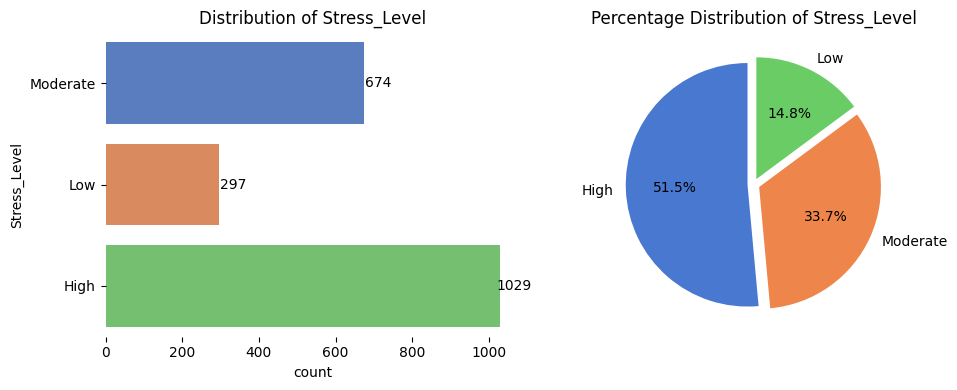

In [8]:
column_name = 'Stress_Level'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')  
plt.title(f'Distribution of {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Percentage Distribution of {column_name}')
plt.ylabel('')  

plt.tight_layout()
plt.show()

Wawasan

**Distribusi Stress_Level**

* **High:** Paling umum, memengaruhi 51.5% siswa (1,029). Ini menunjukkan bahwa lebih dari setengah siswa mengalami stres yang signifikan, kemungkinan dipengaruhi oleh faktor akademik, sosial, atau gaya hidup.
* **Moderate:** Paling sering kedua, dengan 33.7% siswa (674), menunjukkan kelompok yang cukup besar mampu mengelola stres dengan cukup baik.
* **Low:** Hanya 14.8% siswa (297) yang termasuk dalam kategori ini, menunjukkan bahwa sebagian kecil mempertahankan gaya hidup seimbang dan rendah stres.

**Pengamatan Utama**

* **Dominasi High Stress:** Jumlah siswa dengan **High** stress yang besar menyoroti pentingnya menyelidiki penyebab seperti beban akademik yang berat, aktivitas fisik yang terbatas, atau kurang tidur.

* **Moderate Stress:** Sekitar sepertiga siswa berada pada tingkat **Moderate**, menunjukkan keseimbangan yang memadai tetapi belum optimal.

* **Minoritas Low Stress:** Kurang dari 15% siswa berada pada tingkat **Low**, mencerminkan bahwa sangat sedikit yang mencapai keseimbangan optimal antara akademik, kehidupan sosial, dan kesejahteraan pribadi.

**Implikasi**

* Mayoritas (85.2%) berada pada tingkat **Moderate–High**, yang berpotensi berdampak negatif pada performa akademik dan kesehatan secara keseluruhan.

* Institusi atau peneliti dapat mempertimbangkan strategi penurunan stres, seperti meningkatkan **Sleep_Hours_Per_Day**, **Physical_Activity_Hours_Per_Day**, dan keseimbangan **Social_Hours_Per_Day**.


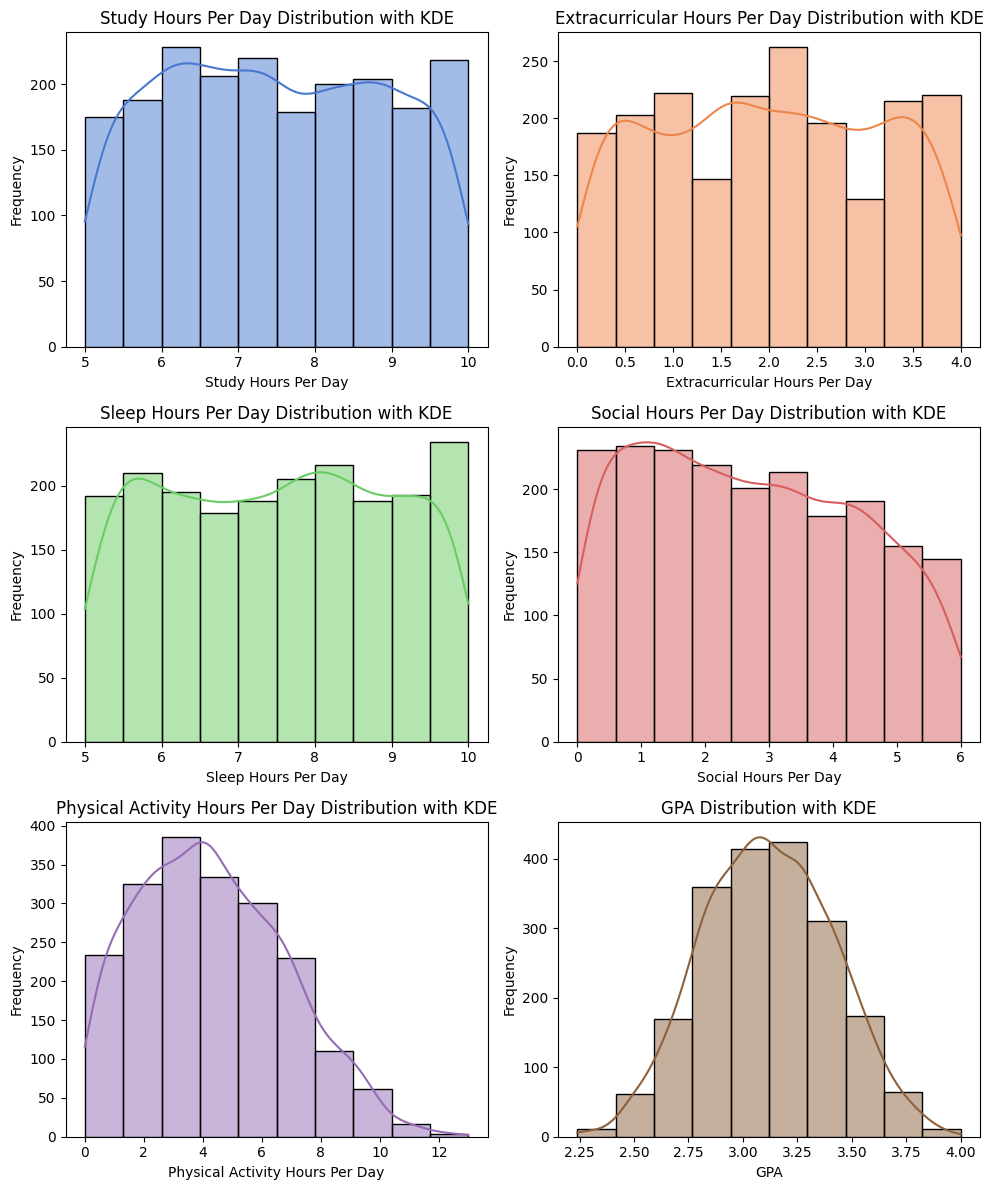

In [9]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, columns):
    plt.figure(figsize=(10, 12))  
    
    muted_colors = sns.color_palette("muted", len(columns))
    
    for i, column in enumerate(columns):
        plt.subplot(3, 2, i + 1)  
        sns.histplot(data[column], kde=True, bins=10, color=muted_colors[i])
        plt.title(f'{column.replace("_", " ")} Distribution with KDE')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 
                       'Physical_Activity_Hours_Per_Day', 'GPA']

univariate_analysis(df, columns_to_analyze)

Wawasan tentang Kebiasaan Harian dan IPK

**Study_Hours_Per_Day**

* Distribusi sedikit condong ke kanan, sebagian besar siswa belajar **6–8 jam setiap hari**.

* Hanya sedikit yang meluangkan **lebih dari 9 jam** untuk belajar.

**Extracurricular_Hours_Per_Day**

* Pola condong ke kiri, mayoritas menghabiskan **0–2 jam** untuk kegiatan ekstrakurikuler.

* Sebagian kecil siswa menghabiskan **3–4 jam**.

**Sleep_Hours_Per_Day**

* Distribusi hampir normal, berpusat di sekitar **7–8 jam** tidur.

* Sangat sedikit siswa yang tidur **kurang dari 6 jam** atau **lebih dari 9 jam**.

**Social_Hours_Per_Day**

* Condong ke kanan, sebagian besar menghabiskan **1–3 jam** untuk bersosialisasi.

* Beberapa siswa menghabiskan **4+ jam**, membentuk kelompok yang lebih kecil.

**Physical_Activity_Hours_Per_Day**

* Condong ke kanan, sebagian besar melakukan aktivitas fisik selama **2–5 jam** setiap hari.

* Beberapa melebihi **8 jam**, dengan beberapa yang melampaui **10 jam**.

**GPA**

* Distribusi cukup normal, puncaknya sekitar **3.0–3.2**.

* Hanya sedikit siswa yang mencapai mendekati **4.0**, sementara sangat sedikit yang berada di bawah **2.5**.

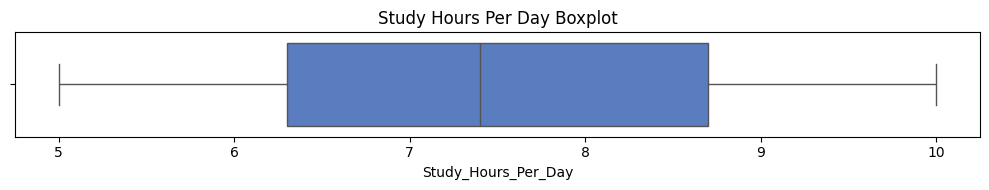


Summary Statistics for Study Hours Per Day:
 count    2000.000000
mean        7.475800
std         1.423888
min         5.000000
25%         6.300000
50%         7.400000
75%         8.700000
max        10.000000
Name: Study_Hours_Per_Day, dtype: float64


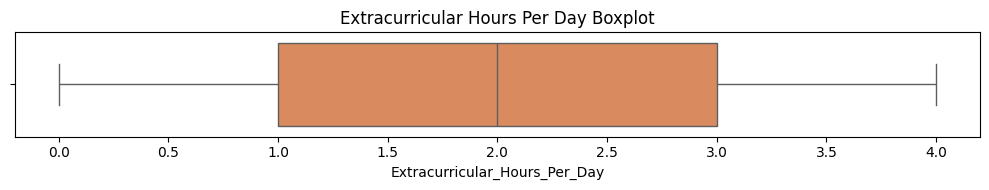


Summary Statistics for Extracurricular Hours Per Day:
 count    2000.000000
mean        1.990100
std         1.155855
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Extracurricular_Hours_Per_Day, dtype: float64


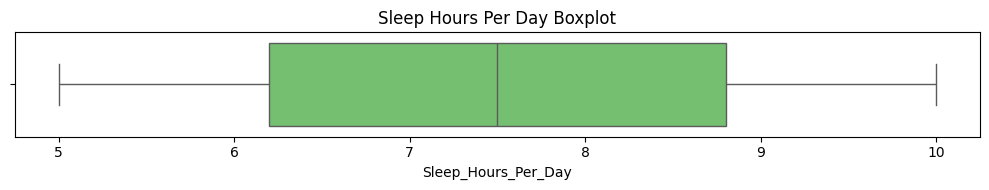


Summary Statistics for Sleep Hours Per Day:
 count    2000.000000
mean        7.501250
std         1.460949
min         5.000000
25%         6.200000
50%         7.500000
75%         8.800000
max        10.000000
Name: Sleep_Hours_Per_Day, dtype: float64


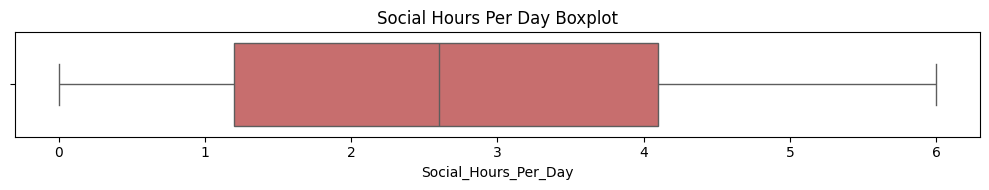


Summary Statistics for Social Hours Per Day:
 count    2000.000000
mean        2.704550
std         1.688514
min         0.000000
25%         1.200000
50%         2.600000
75%         4.100000
max         6.000000
Name: Social_Hours_Per_Day, dtype: float64


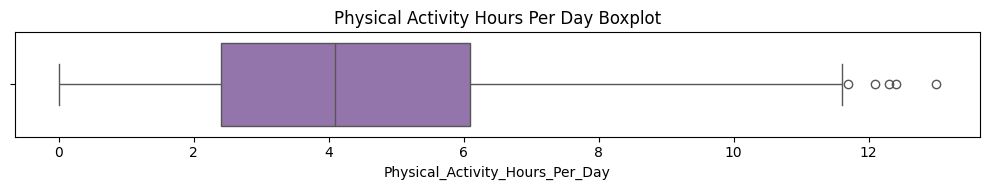


Summary Statistics for Physical Activity Hours Per Day:
 count    2000.00000
mean        4.32830
std         2.51411
min         0.00000
25%         2.40000
50%         4.10000
75%         6.10000
max        13.00000
Name: Physical_Activity_Hours_Per_Day, dtype: float64


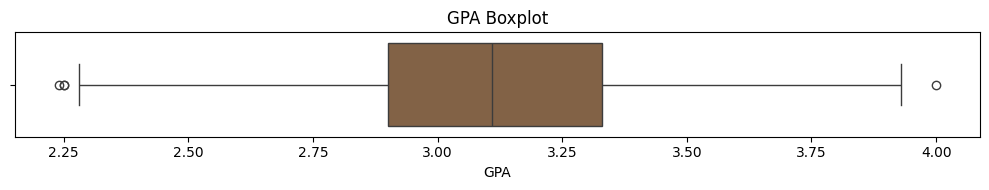


Summary Statistics for GPA:
 count    2000.000000
mean        3.115960
std         0.298674
min         2.240000
25%         2.900000
50%         3.110000
75%         3.330000
max         4.000000
Name: GPA, dtype: float64


In [10]:
# Function to perform univariate analysis for numeric columns
def univariate_analysis(data, column, title):
    plt.figure(figsize=(10, 2))
    
    # Define a muted color palette
    color = sns.color_palette("muted")[columns_to_analyze.index(column)]
    
    sns.boxplot(x=data[column], color=color)
    plt.title(f'{title} Boxplot')
    
    plt.tight_layout()
    plt.show()

    print(f'\nSummary Statistics for {title}:\n', data[column].describe())

# List of columns to analyze
columns_to_analyze = ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 
                       'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 
                       'Physical_Activity_Hours_Per_Day', 'GPA']

# Iterate through columns and perform univariate analysis
for column in columns_to_analyze:
    univariate_analysis(df, column, column.replace('_', ' '))

Wawasan tentang Rutinitas Mahasiswa dan IPK

**1. Study_Hours_Per_Day**

* **Rentang:** 5–10 jam
* **Median:** 7.4 jam, mendekati rata-rata 7.48 jam
* **IQR:** 6.3–8.7 jam
* Nilai ekstrem jarang ditemukan, menunjukkan sebagian besar mahasiswa mengikuti rutinitas belajar yang konsisten

**2. Extracurricular_Hours_Per_Day**

* **Rentang:** 0–4 jam
* **Median:** 2 jam, mirip dengan rata-rata 1.99 jam
* **IQR:** 1–3 jam
* Nilai ekstrem jarang ditemukan, sebagian besar mahasiswa berpartisipasi secara moderat dalam kegiatan ekstrakurikuler

**3. Sleep_Hours_Per_Day**

* **Rentang:** 5–10 jam
* **Median:** 7.5 jam, sama dengan rata-rata 7.50 jam
* **IQR:** 6.2–8.8 jam
* Sedikitnya nilai outlier menunjukkan pola tidur yang konsisten

**4. Social_Hours_Per_Day**

* **Rentang:** 0–6 jam
* **Median:** 2.6 jam, sedikit di bawah rata-rata 2.70 jam
* **IQR:** 1.2–4.1 jam
* Nilai outlier di kedua ujung menunjukkan kebiasaan sosial yang beragam

**5. Physical_Activity_Hours_Per_Day**

* **Rentang:** 0–13 jam
* **Median:** 4.1 jam, mendekati rata-rata 4.33 jam
* **IQR:** 2.4–6.1 jam
* Nilai outlier yang signifikan menunjukkan beberapa siswa melakukan aktivitas fisik yang luar biasa tinggi

**6. GPA**

* **Rentang:** 2.24–4.0
* **Median:** 3.11, mendekati rata-rata 3.12
* **IQR:** 2.9–3.33
* Sedikit nilai ekstrem menunjukkan sebagian besar siswa mencapai prestasi akademik sedang hingga tinggi

**Pengamatan Utama**

* **Pola Konsisten:** Study_Hours_Per_Day, Sleep_Hours_Per_Day, dan GPA memiliki nilai ekstrem yang terbatas, mencerminkan perilaku seragam di antara siswa
* **Keterlibatan yang Beragam:** Social_Hours_Per_Day dan Physical_Activity_Hours_Per_Day menunjukkan variabilitas yang lebih besar, menyoroti pilihan dan kebiasaan gaya hidup yang berbeda


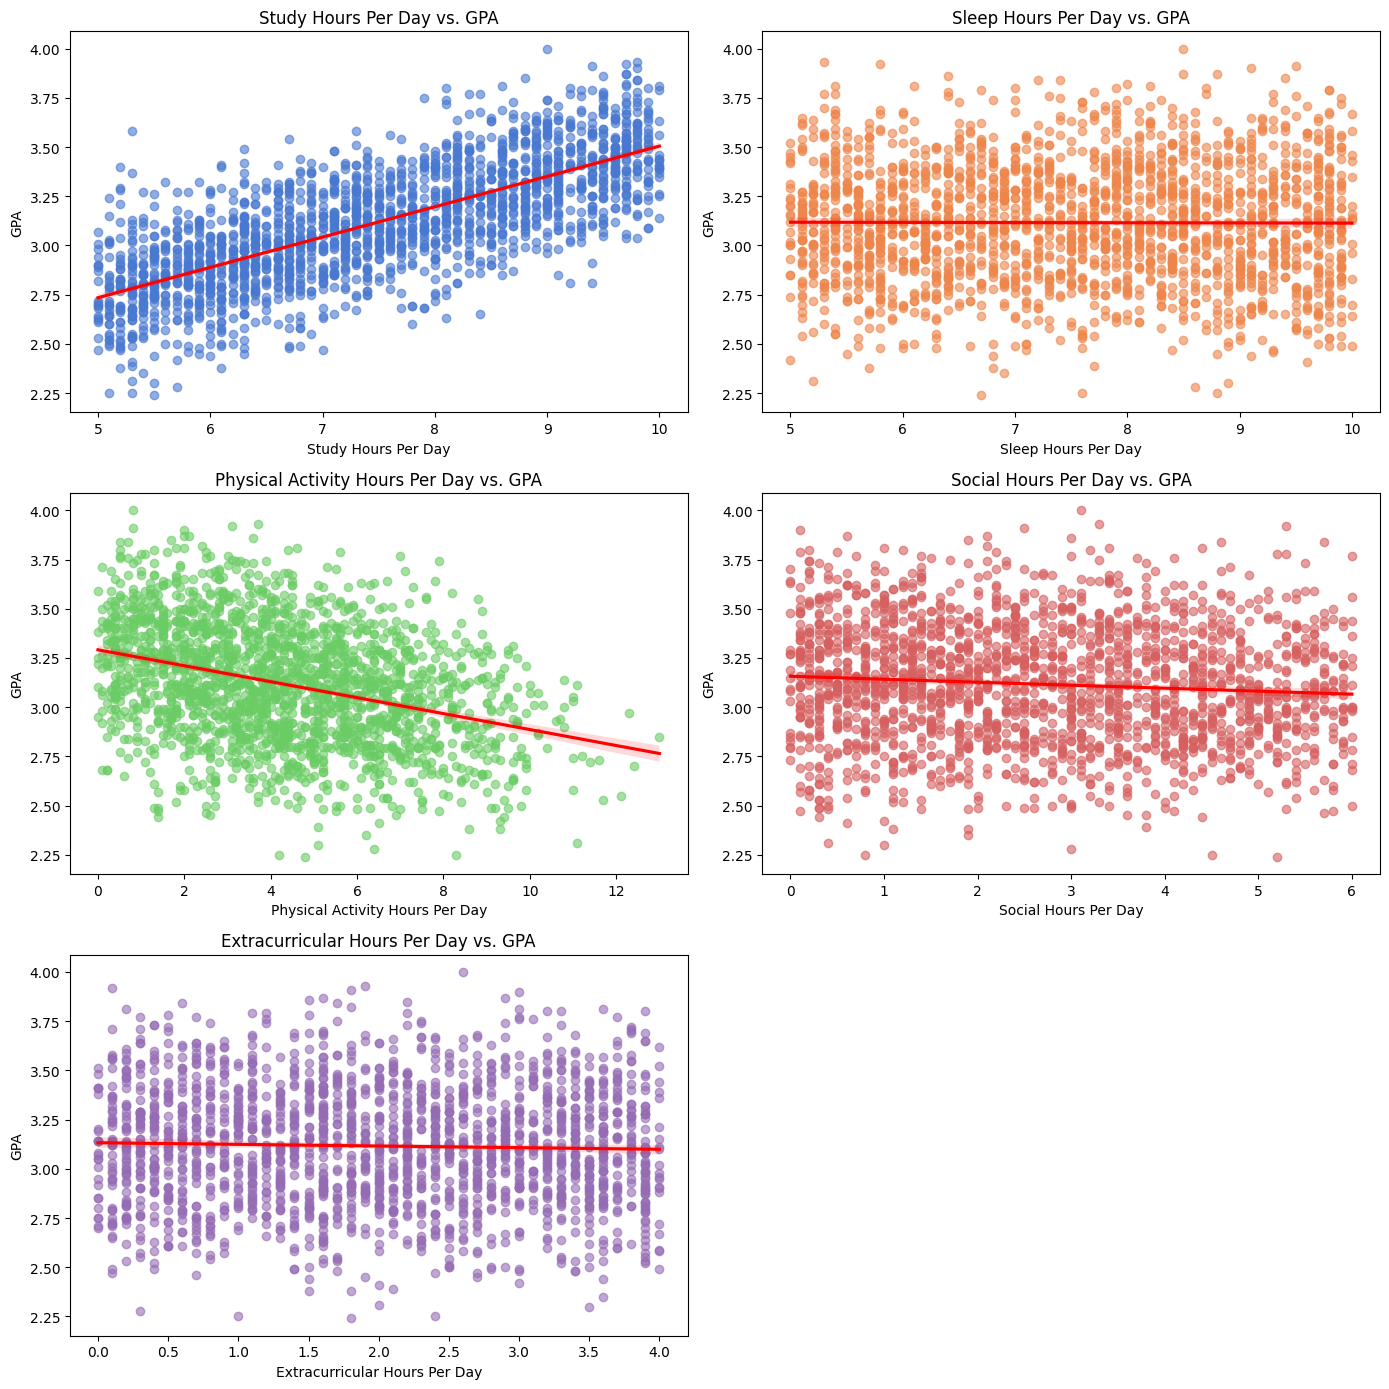

In [11]:
# Define muted colors from the palette
muted_colors = sns.color_palette("muted")

# Scatter plots with linear regression lines 
plt.figure(figsize=(14, 14))

# Study Hours vs. GPA
plt.subplot(3, 2, 1)
sns.regplot(x='Study_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[0], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Study Hours Per Day vs. GPA')
plt.xlabel('Study Hours Per Day')
plt.ylabel('GPA')

# Sleep Hours vs. GPA
plt.subplot(3, 2, 2)
sns.regplot(x='Sleep_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[1], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Sleep Hours Per Day vs. GPA')
plt.xlabel('Sleep Hours Per Day')
plt.ylabel('GPA')

# Physical Activity Hours vs. GPA
plt.subplot(3, 2, 3)
sns.regplot(x='Physical_Activity_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[2], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Physical Activity Hours Per Day vs. GPA')
plt.xlabel('Physical Activity Hours Per Day')
plt.ylabel('GPA')

# Social Hours vs. GPA
plt.subplot(3, 2, 4)
sns.regplot(x='Social_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[3], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Social Hours Per Day vs. GPA')
plt.xlabel('Social Hours Per Day')
plt.ylabel('GPA')

# Extracurricular Hours vs. GPA
plt.subplot(3, 2, 5)
sns.regplot(x='Extracurricular_Hours_Per_Day', y='GPA', data=df,
            color=muted_colors[4], scatter_kws={'alpha':0.6}, line_kws={'color': 'red'})
plt.title('Extracurricular Hours Per Day vs. GPA')
plt.xlabel('Extracurricular Hours Per Day')
plt.ylabel('GPA')

plt.tight_layout()
plt.show()

Wawasan tentang Hubungan Linier

**Study_Hours_Per_Day vs. GPA**

* **Hubungan Positif yang Kuat:** Seiring bertambahnya jam belajar, GPA meningkat secara signifikan.
* Ini menegaskan bahwa menghabiskan lebih banyak waktu untuk belajar umumnya meningkatkan prestasi akademik.

**Sleep_Hours_Per_Day vs. GPA**

* **Tidak Ada Hubungan yang Jelas:** Garis regresi hampir datar, menunjukkan sedikit atau tidak ada korelasi.
* Variasi dalam tidur tampaknya tidak memengaruhi GPA, asalkan siswa mendapatkan istirahat yang cukup.

**Physical_Activity_Hours_Per_Day vs. GPA**

* **Hubungan Negatif Sedang:** Tren menurun sedikit, aktivitas fisik yang lebih banyak dikaitkan dengan penurunan GPA yang kecil.
* Menunjukkan adanya sedikit pertukaran antara waktu olahraga dan fokus akademik, meskipun efeknya terbatas.

**Social_Hours_Per_Day vs. GPA**

* **Hubungan Negatif yang Lemah:** Kemiringan menurun sedikit menunjukkan bahwa sosialisasi yang berlebihan dapat sedikit mengurangi GPA.
* Interaksi sosial yang moderat umumnya tidak berbahaya bagi prestasi akademik.

**Extracurricular_Hours_Per_Day vs. GPA**

* **Tidak Ada Hubungan Signifikan:** Garis regresi datar, menunjukkan keterlibatan ekstrakurikuler tidak secara langsung memengaruhi GPA.

**Pengamatan Keseluruhan**

* **Study_Hours_Per_Day Paling Penting:** Jam belajar memiliki dampak positif terkuat pada GPA.

* **Gaya Hidup Seimbang:** Physical_Activity_Hours_Per_Day dan Social_Hours_Per_Day memiliki efek negatif kecil tetapi penting untuk kesejahteraan secara keseluruhan.

* **Sleep_Hours_Per_Day Bersifat Netral:** Tidur yang cukup tidak secara signifikan mengubah GPA.

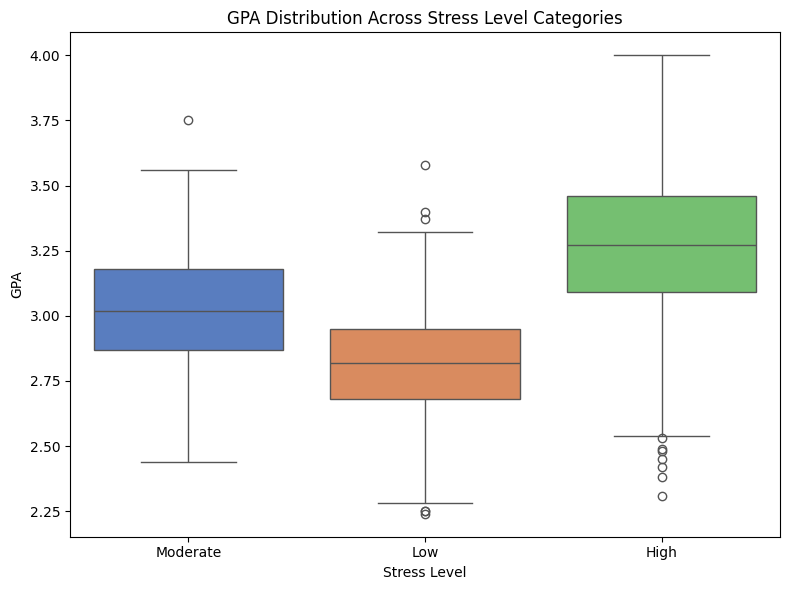

In [12]:
# Boxplot for GPA across different Stress_Level categories
plt.figure(figsize=(8, 6))
sns.boxplot(x='Stress_Level', y='GPA', data=df, palette='muted')

plt.title('GPA Distribution Across Stress Level Categories')
plt.xlabel('Stress Level')
plt.ylabel('GPA')

# Display the plot
plt.tight_layout()
plt.show()

Wawasan tentang GPA berdasarkan Stress_Level

**Low**

* **GPA Median:** Sedikit lebih rendah dibandingkan kelompok lain
* **Sebaran:** IQR sempit, menunjukkan GPA yang lebih konsisten tetapi lebih rendah
* **Wawasan:** Mahasiswa dengan Stress_Level rendah mungkin tidak mencapai GPA tertinggi, kemungkinan karena tekanan akademik yang lebih rendah

**Moderate**

* **GPA Median:** Sedikit lebih tinggi dibandingkan mahasiswa dengan Stress_Level rendah
* **Sebaran:** IQR lebih luas, menunjukkan kinerja akademik yang bervariasi
* **Wawasan:** Stress_Level sedang tampaknya ideal untuk menyeimbangkan produktivitas dan pencapaian akademik yang baik

**High**

* **GPA Median:** Tertinggi di antara semua kelompok
* **Sebaran:** IQR terluas, dengan pencapaian tinggi dan beberapa outlier rendah
* **Wawasan:** Stress_Level tinggi dapat mendorong keunggulan bagi sebagian mahasiswa tetapi berdampak negatif bagi mahasiswa lainnya

**Pengamatan Utama**

* **Moderate:** Cenderung mendukung GPA yang stabil dan di atas rata-rata, serta berpotensi menjadi tingkat Stress_Level yang optimal
* **High:** Bertindak sebagai pedang bermata dua, dapat meningkatkan performa bagi sebagian mahasiswa namun merugikan yang lain
* **Low:** Umumnya dikaitkan dengan GPA median yang lebih rendah, menunjukkan bahwa tekanan minimal mungkin tidak memaksimalkan hasil akademik

**Kesimpulan**

* Mencapai Stress_Level yang seimbang tampaknya sangat penting untuk memperoleh hasil akademik yang optimal.


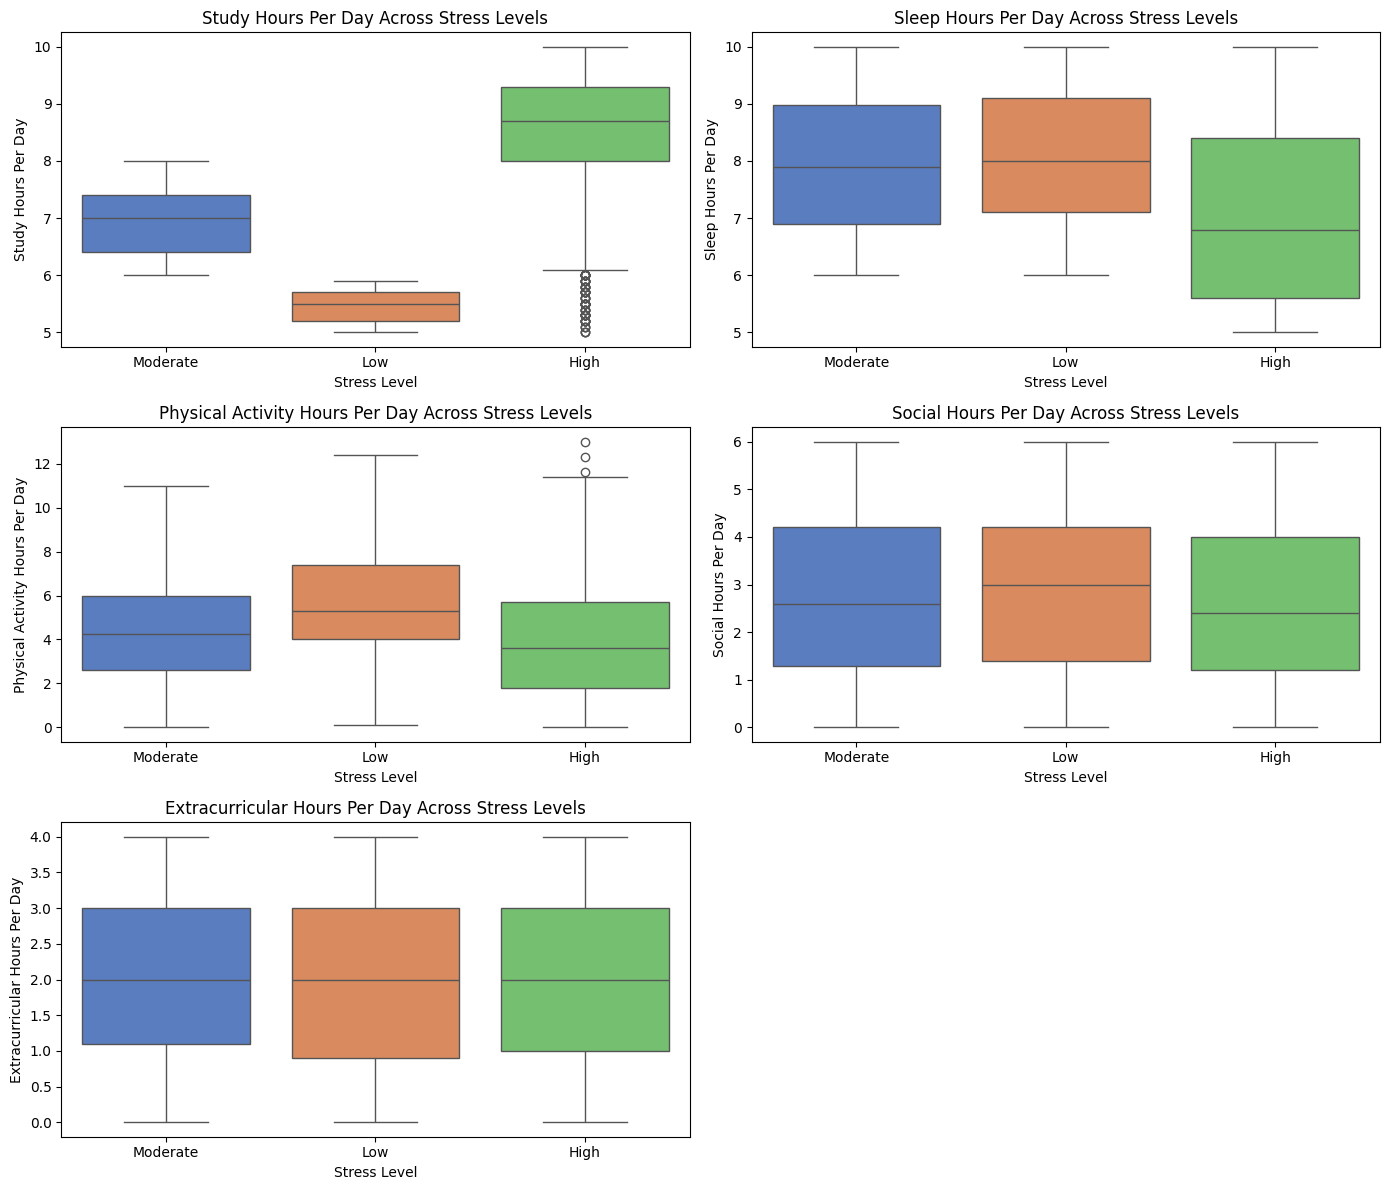

In [13]:
numerical_features = [
    'Study_Hours_Per_Day', 
    'Sleep_Hours_Per_Day', 
    'Physical_Activity_Hours_Per_Day', 
    'Social_Hours_Per_Day', 
    'Extracurricular_Hours_Per_Day'
]

# Create boxplots for each numerical feature grouped by Stress_Level
plt.figure(figsize=(14, 12))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Stress_Level', y=feature, data=df, palette='muted')
    plt.title(f'{feature.replace("_", " ")} Across Stress Levels')
    plt.xlabel('Stress Level')
    plt.ylabel(feature.replace("_", " "))

plt.tight_layout()
plt.show()

Wawasan tentang Aktivitas Harian berdasarkan Stress_Level

**Study_Hours_Per_Day**

* **High:** Mahasiswa paling banyak belajar dan memiliki rentang jam belajar yang lebih luas, kemungkinan berkontribusi pada Stress_Level yang lebih tinggi.

* **Moderate:** Median jam belajar lebih rendah dibandingkan High, tetapi masih signifikan.

* **Low:** Mahasiswa paling sedikit belajar, mencerminkan pendekatan akademik yang lebih santai.

**Sleep_Hours_Per_Day**

* **High:** Median tidur sedikit lebih tinggi, tetapi rentang keseluruhan serupa di semua tingkat Stress_Level.

* **Moderate & Low:** Pola tidur cukup konsisten, menunjukkan Stress_Level memiliki sedikit pengaruh terhadap durasi tidur.

**Physical_Activity_Hours_Per_Day**

* **Moderate & Low:** Mahasiswa lebih banyak melakukan aktivitas fisik, berpotensi sebagai strategi manajemen stres.

* **High:** Median aktivitas fisik lebih rendah; tuntutan akademik kemungkinan mengurangi waktu berolahraga.

**Social_Hours_Per_Day**

* Median dan rentang nilai serupa pada seluruh kelompok Stress_Level.

* Interaksi sosial relatif stabil terlepas dari Stress_Level.

**Extracurricular_Hours_Per_Day**

* Median dan rentang nilai konsisten di seluruh tingkat Stress_Level.

* Partisipasi dalam kegiatan ekstrakurikuler tampaknya tidak terlalu dipengaruhi oleh Stress_Level.

**Pengamatan Utama**

* **Study_Hours_Per_Day:** Berkaitan erat dengan Stress_Level; semakin banyak waktu belajar berkorelasi dengan Stress_Level yang lebih tinggi.

* **Physical_Activity_Hours_Per_Day:** Lebih umum pada mahasiswa dengan Stress_Level Low dan Moderate; mahasiswa dengan Stress_Level High cenderung memprioritaskan akademik.

* **Sleep_Hours_Per_Day & Social_Hours_Per_Day:** Variasi minimal, menunjukkan dampak Stress_Level yang lebih kecil.

* **Extracurricular_Hours_Per_Day:** Distribusi relatif seragam, menunjukkan Stress_Level memiliki pengaruh yang terbatas terhadap partisipasi.


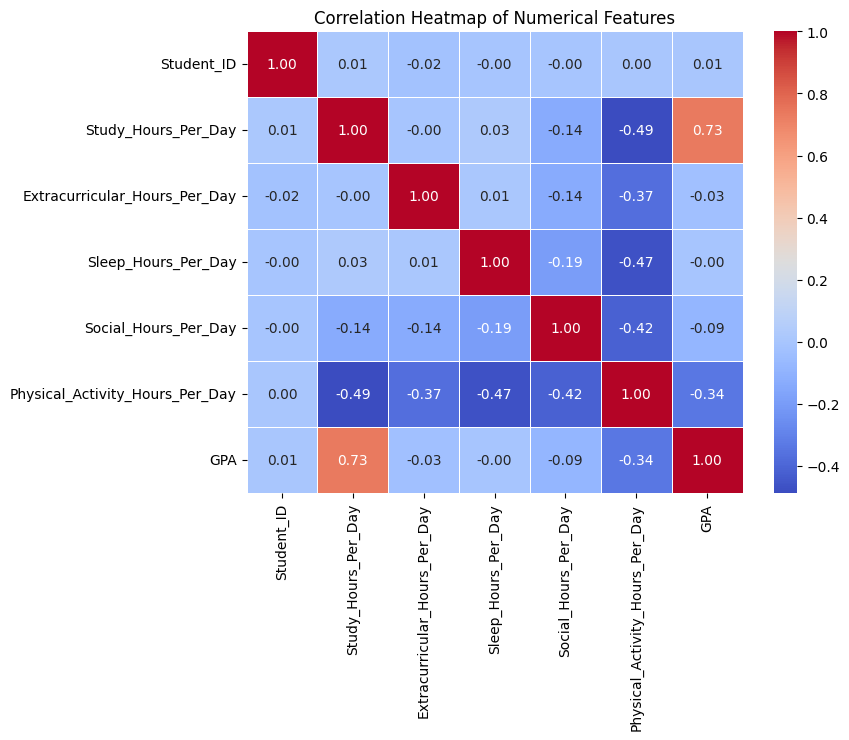

In [14]:
# Plotting a correlation heatmap for numerical variables
plt.figure(figsize=(8, 6))
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Wawasan Observasional dari Heatmap Korelasi

**Korelasi Utama**

* **Study_Hours_Per_Day & GPA:**
Korelasi positif yang kuat (**0.73**). Mahasiswa yang lebih banyak meluangkan waktu untuk belajar umumnya mencapai GPA yang lebih tinggi, menyoroti pentingnya belajar secara konsisten.

* **Physical_Activity_Hours_Per_Day & Study_Hours_Per_Day:**
Korelasi negatif sedang (**-0.49**). Lebih banyak waktu yang dihabiskan untuk berolahraga cenderung mengurangi jam belajar, kemungkinan karena keterbatasan waktu.

* **Physical_Activity_Hours_Per_Day & GPA:**
Korelasi negatif sedang (**-0.34**). Aktivitas fisik yang lebih tinggi mungkin sedikit menurunkan GPA, kemungkinan karena membatasi waktu belajar.

* **Social_Hours_Per_Day & GPA:**
Korelasi negatif lemah (**-0.09**). Bersosialisasi memiliki dampak minimal pada GPA, meskipun waktu sosial yang berlebihan dapat sedikit mengurangi prestasi akademik.

* **Extracurricular_Hours_Per_Day & GPA:**
Korelasi mendekati nol (**-0.03**). Partisipasi dalam kegiatan ekstrakurikuler tampaknya memiliki sedikit pengaruh langsung terhadap GPA.

* **Sleep_Hours_Per_Day & GPA:**
Tidak ada korelasi yang berarti (**0.00**). Durasi tidur tidak secara langsung memengaruhi GPA, meskipun manfaat tidak langsung seperti peningkatan fokus tetap relevan.

**Pengamatan Keseluruhan**

* **Study_Hours_Per_Day** merupakan prediktor terkuat terhadap GPA.
* **Physical_Activity_Hours_Per_Day** memiliki pengaruh sedang terhadap Study_Hours_Per_Day dan GPA, menekankan pentingnya keseimbangan.

* **Social_Hours_Per_Day** dan **Extracurricular_Hours_Per_Day** memiliki pengaruh langsung yang minimal terhadap GPA, tetapi dapat memengaruhi Stress_Level dan kesejahteraan secara keseluruhan.

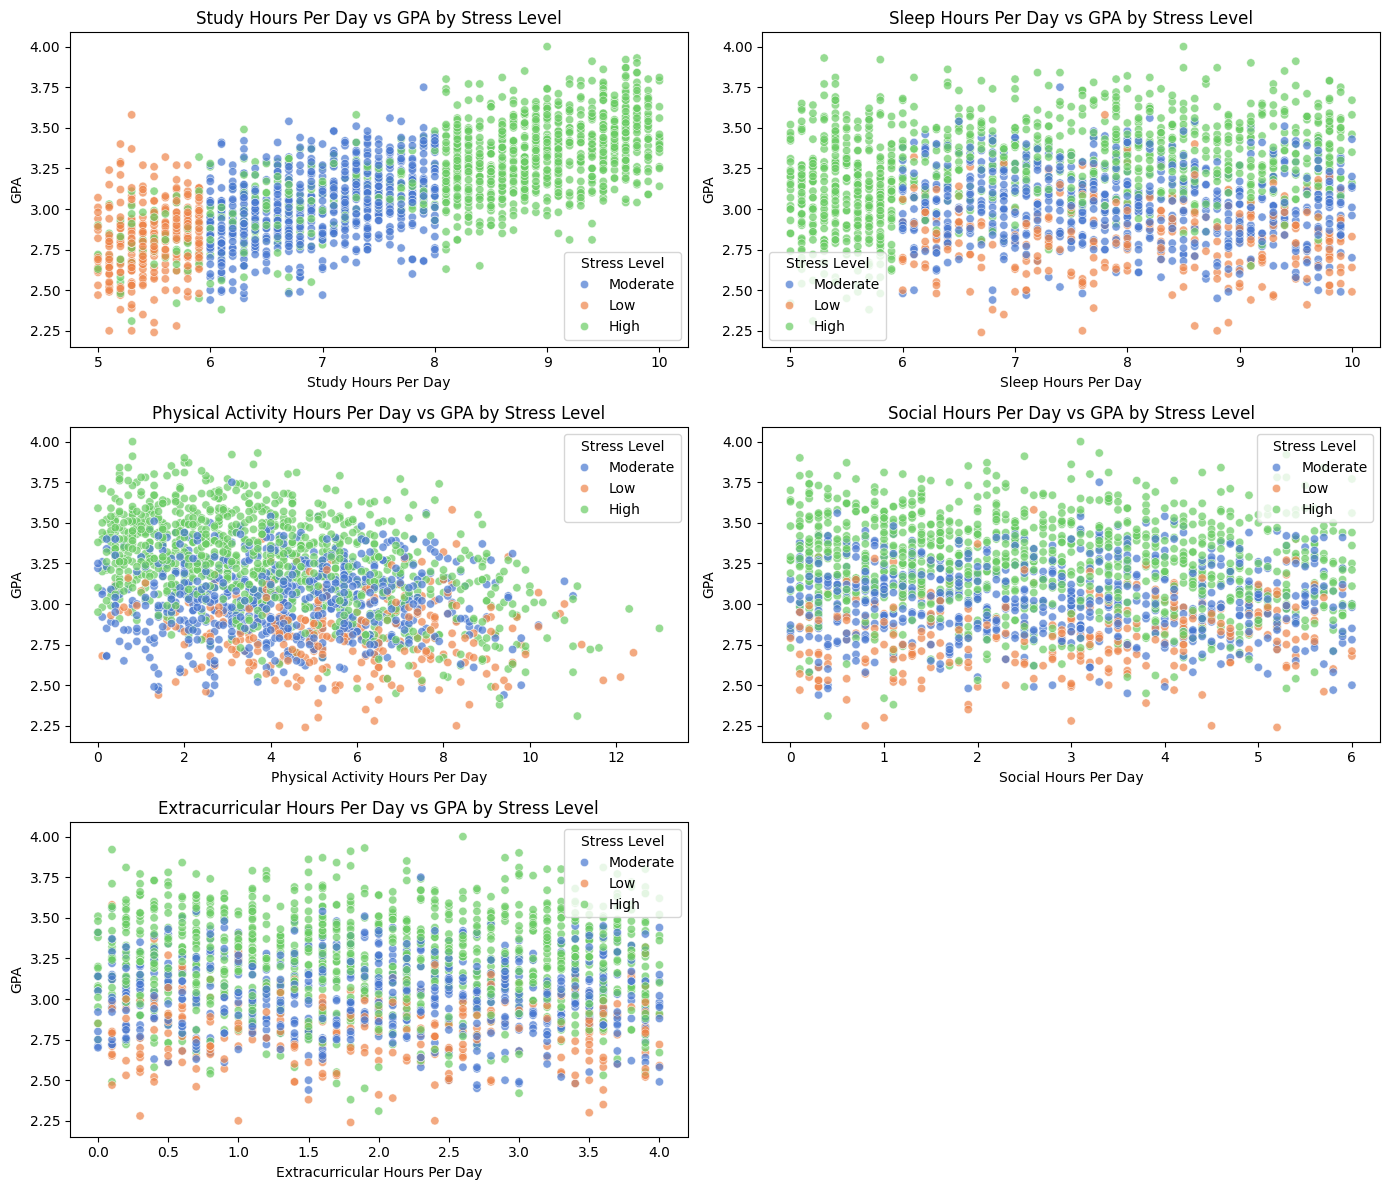

In [15]:
# Numerical features against GPA, grouped by Stress_Level
plt.figure(figsize=(14, 12))

numerical_features = [
    'Study_Hours_Per_Day', 
    'Sleep_Hours_Per_Day', 
    'Physical_Activity_Hours_Per_Day', 
    'Social_Hours_Per_Day', 
    'Extracurricular_Hours_Per_Day'
]

# Plot each feature
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(
        x=feature, 
        y='GPA', 
        hue='Stress_Level', 
        data=df, 
        palette='muted', 
        alpha=0.7
    )
    plt.title(f'{feature.replace("_", " ")} vs GPA by Stress Level')
    plt.xlabel(feature.replace('_', ' '))
    plt.ylabel('GPA')
    plt.legend(title='Stress Level')

plt.tight_layout()
plt.show()


Wawasan dari Variabel Numerik vs. GPA berdasarkan Stress_Level

**Study_Hours_Per_Day vs. GPA**

* **High:** Mahasiswa yang belajar lebih banyak saat berada pada Stress_Level tinggi seringkali mencapai GPA yang lebih tinggi.

* **Moderate:** Mahasiswa dengan Stress_Level sedang dan jam belajar yang wajar menunjukkan rentang GPA yang luas, menandakan pentingnya keseimbangan.

* **Low:** Mahasiswa dengan Stress_Level rendah cenderung memiliki GPA sedang, terlepas dari jam belajar.

**Sleep_Hours_Per_Day vs. GPA**

* Tidak ada pola yang jelas pada seluruh tingkat Stress_Level.

* Mahasiswa dengan GPA tinggi tersebar di berbagai durasi tidur.

* **Wawasan:** Sleep_Hours_Per_Day tidak secara signifikan memengaruhi GPA pada kategori Stress_Level mana pun.

**Physical_Activity_Hours_Per_Day vs. GPA**

* **High:** Mahasiswa umumnya memiliki tingkat aktivitas fisik yang lebih rendah; mereka yang berolahraga menunjukkan GPA yang bervariasi.

* **Moderate:** Tingkat aktivitas fisik sedang dikaitkan dengan GPA yang layak dengan hasil yang beragam.

* **Low:** Aktivitas fisik yang lebih tinggi menunjukkan GPA yang bervariasi, menandakan dampak langsung yang terbatas terhadap performa akademik.

**Social_Hours_Per_Day vs. GPA**

* Tidak ditemukan korelasi yang kuat pada seluruh tingkat Stress_Level.

* **High:** GPA relatif konsisten meskipun Social_Hours_Per_Day bervariasi.

* **Moderate:** Social_Hours_Per_Day sangat bervariasi, tetapi distribusi GPA tetap merata.

* **Low:** Pola serupa; interaksi sosial memiliki pengaruh minimal terhadap GPA.

**Extracurricular_Hours_Per_Day vs. GPA**

* Pada seluruh tingkat Stress_Level, tidak terdapat hubungan yang jelas antara Extracurricular_Hours_Per_Day dan GPA.

* Mahasiswa yang berpartisipasi dalam 0–4 jam aktivitas mempertahankan GPA yang beragam, menunjukkan bahwa aktivitas ini tidak secara langsung meningkatkan hasil akademik, meskipun keterlibatan berlebihan berpotensi sedikit menghambat performa.


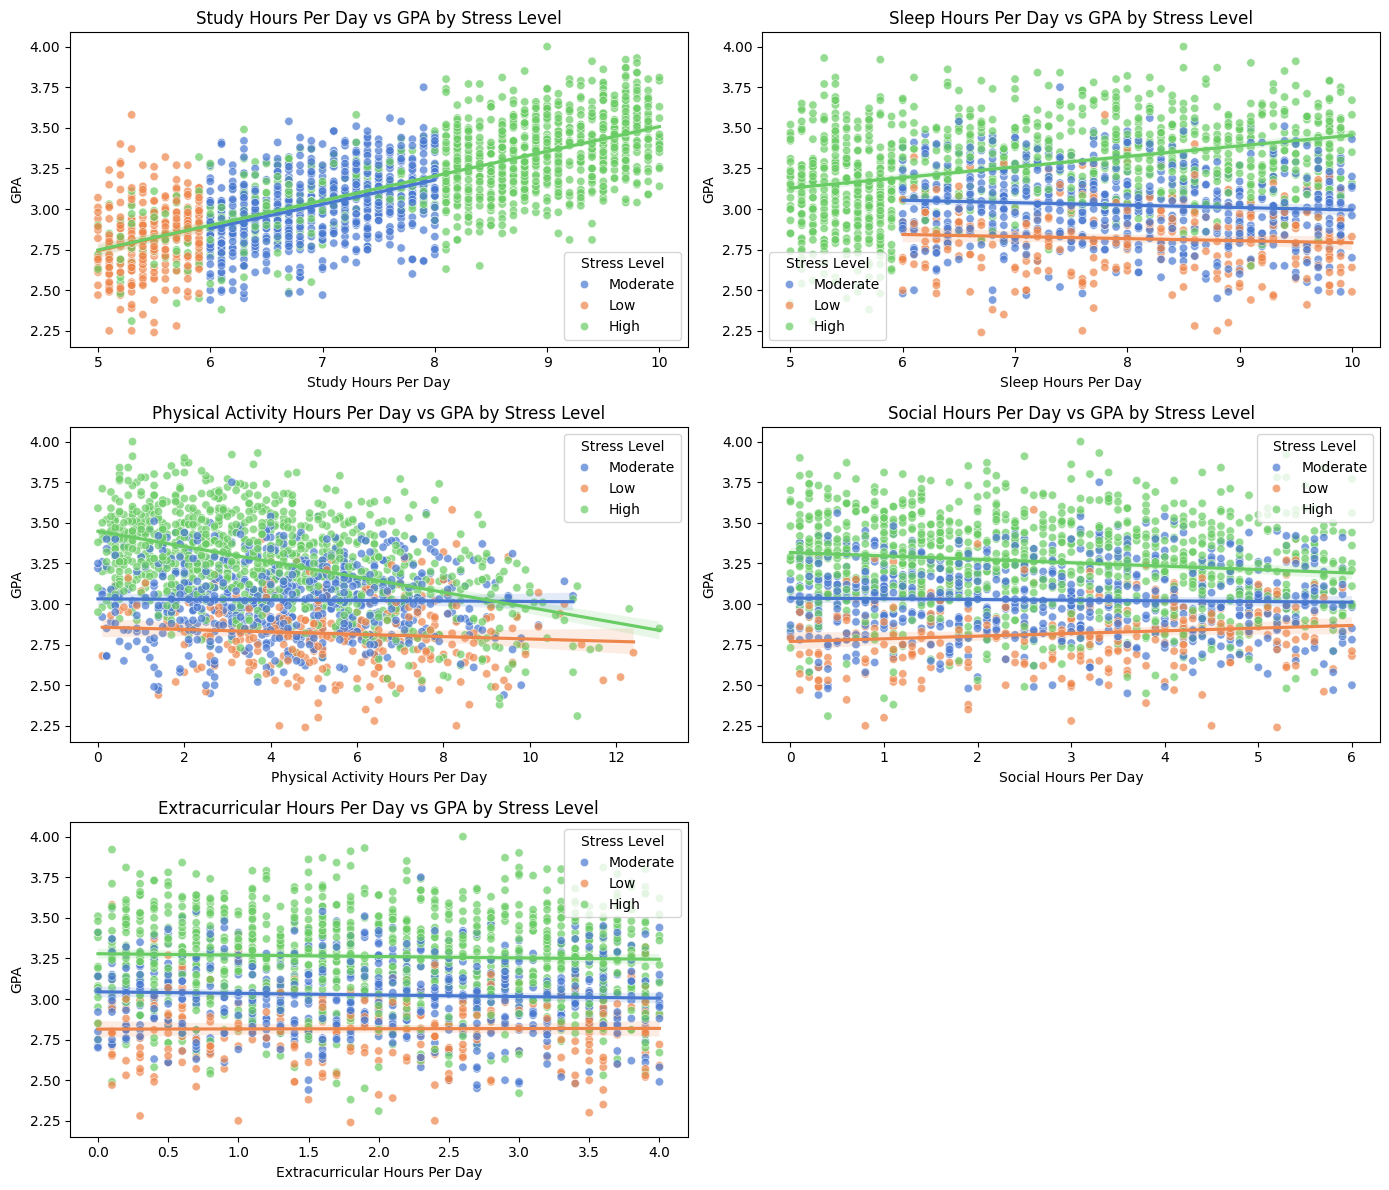

In [16]:
plt.figure(figsize=(14, 12))

numerical_features = [
    'Study_Hours_Per_Day', 
    'Sleep_Hours_Per_Day', 
    'Physical_Activity_Hours_Per_Day', 
    'Social_Hours_Per_Day', 
    'Extracurricular_Hours_Per_Day'
]

# Define colors for different stress levels
stress_colors = sns.color_palette('muted')

# Plot each feature
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    
    # Scatter plot with matching colors for stress levels
    sns.scatterplot(
        x=feature,
        y='GPA',
        hue='Stress_Level',
        data=df,
        palette=stress_colors,
        alpha=0.7
    )
    
    # Add linear regression lines for each stress level with matching colors
    for j, stress_level in enumerate(df['Stress_Level'].unique()):
        sns.regplot(
            x=feature,
            y='GPA',
            data=df[df['Stress_Level'] == stress_level],
            scatter=False,
            color=stress_colors[j], # Use the same color for the line as in the scatter plot
            line_kws={'label': stress_level}
        )
    
    plt.title(f'{feature.replace("_", " ")} vs GPA by Stress Level')
    plt.xlabel(feature.replace('_', ' '))
    plt.ylabel('GPA')
    plt.legend(title='Stress Level')

plt.tight_layout()
plt.show()

Wawasan dari Scatter Plot dengan Linear Regression

**Study_Hours_Per_Day**

* Korelasi positif yang kuat dengan GPA, terutama pada mahasiswa dengan Stress_Level **High** dan **Moderate**.

* Lebih banyak waktu belajar umumnya mengarah pada performa akademik yang lebih baik.

**Physical_Activity_Hours_Per_Day**

* Tingkat aktivitas fisik yang tinggi dapat sedikit menurunkan GPA pada mahasiswa dengan Stress_Level **High**.

* Menunjukkan adanya pertukaran kecil antara waktu berolahraga dan waktu belajar di bawah tekanan.

**Sleep_Hours_Per_Day, Social_Hours_Per_Day, dan Extracurricular_Hours_Per_Day**

* Variabel-variabel ini menunjukkan dampak langsung yang minimal terhadap GPA pada seluruh tingkat Stress_Level.

* Pengaruhnya kemungkinan bersifat tidak langsung, lebih mendukung kesejahteraan secara keseluruhan dibandingkan hasil akademik.

**Stress_Level**

* **High:** Memperkuat hubungan antara Study_Hours_Per_Day dan GPA.

* **Low:** Melemahkan hubungan antara Study_Hours_Per_Day dan GPA, menunjukkan tekanan akademik yang lebih rendah.


In [17]:
# Define thresholds for low and high GPA
low_gpa_threshold = 2.5
high_gpa_threshold = 3.5  

# Filter students with low GPA (less than or equal to the threshold)
low_gpa_students = df[df['GPA'] <= low_gpa_threshold][
    ['GPA', 'Study_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']
]

# Display results in a clear format
print("----- Students with Low GPA (<= 2.5) -----")
display(low_gpa_students)

# Filter students with high GPA (equal to the threshold)
high_gpa_students = df[df['GPA'] >= high_gpa_threshold][
    ['GPA', 'Study_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']
]

# Display results in a clear format
print("\n----- Students with High GPA (>= 3.5) -----")
display(high_gpa_students)

----- Students with Low GPA (<= 2.5) -----


GPA  Study_Hours_Per_Day  Physical_Activity_Hours_Per_Day Stress_Level
32    2.47                  5.2                              7.9          Low
56    2.39                  5.3                              5.1          Low
134   2.45                  6.3                              2.6     Moderate
158   2.38                  6.1                              9.3         High
165   2.46                  5.8                              2.5          Low
283   2.50                  6.2                              9.8     Moderate
331   2.25                  5.1                              8.3          Low
377   2.28                  5.7                              6.4          Low
382   2.31                  5.3                             11.1         High
504   2.49                  5.2                              4.6          Low
505   2.44                  6.0                              9.4     Moderate
512   2.49                  6.7                              9.1         High
550   2.48                  6.7                              7.5     Moderate
605   2.41                  5.3                              6.5          Low
651   2.49                  5.3                              6.3          Low
659   2.49                  6.1                              1.4     Moderate
742   2.48                  5.2                              6.0         High
764   2.24                  5.5                              4.8          Low
815   2.50                  5.6                              5.5          Low
862   2.45                  5.9                              6.9         High
901   2.48                  6.3                              5.2     Moderate
934   2.49                  5.1                              9.2          Low
997   2.49                  5.8                              9.5          Low
1034  2.38                  5.2                              8.6          Low
1074  2.44                  5.5                              1.4          Low
1122  2.50                  6.0                              2.7     Moderate
1172  2.30                  5.5                              5.1          Low
1388  2.50                  5.7                              6.8          Low
1427  2.47                  7.0                              1.4     Moderate
1443  2.42                  5.7                              9.3         High
1574  2.25                  5.3                              4.2          Low
1686  2.50                  5.1                              5.6          Low
1700  2.35                  5.4                              6.2          Low
1727  2.49                  6.8                              1.3     Moderate
1734  2.50                  6.1                              2.5     Moderate
1851  2.48                  5.9                              7.0          Low
1857  2.47                  5.0                              5.5          Low


----- Students with High GPA (>= 3.5) -----


GPA  Study_Hours_Per_Day  Physical_Activity_Hours_Per_Day Stress_Level
4     3.51                  8.1                              6.6         High
34    3.62                  9.7                              6.3         High
45    3.55                  9.7                              0.6         High
51    4.00                  9.0                              0.8         High
60    3.67                  8.3                              1.3         High
...    ...                  ...                              ...          ...
1939  3.52                  8.1                              2.4         High
1962  3.59                  9.4                              2.9         High
1964  3.54                  9.9                              3.0         High
1987  3.86                  9.5                              3.6         High
1999  3.58                  9.0                              2.9         High

[221 rows x 4 columns]

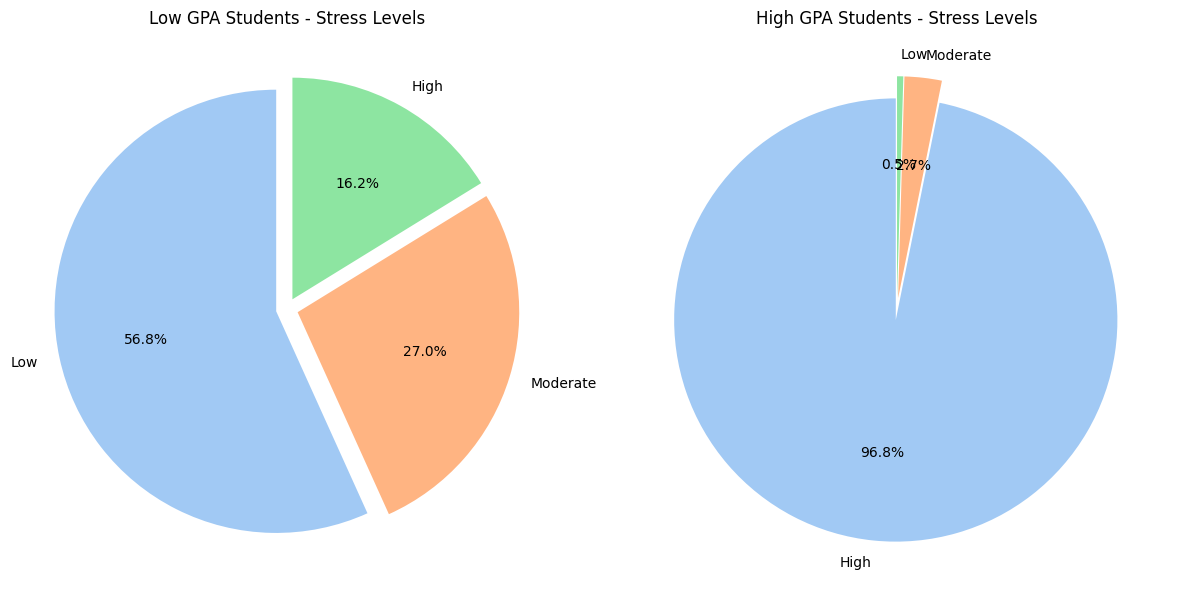

In [18]:
# Prepare data for low GPA students' stress levels
low_gpa_stress_counts = low_gpa_students['Stress_Level'].value_counts()

# Prepare data for high GPA students' stress levels
high_gpa_stress_counts = high_gpa_students['Stress_Level'].value_counts()

# Create subplots for pie charts
plt.figure(figsize=(12, 6))

# Low GPA students' stress levels pie chart
plt.subplot(1, 2, 1)
low_gpa_stress_counts.plot.pie(
    autopct='%1.1f%%', 
    colors=sns.color_palette('pastel'), 
    startangle=90, 
    explode=[0.05] * len(low_gpa_stress_counts), 
    labels=low_gpa_stress_counts.index
)
plt.title('Low GPA Students - Stress Levels')
plt.ylabel('')  

# High GPA students' stress levels pie chart
plt.subplot(1, 2, 2)
high_gpa_stress_counts.plot.pie(
    autopct='%1.1f%%', 
    colors=sns.color_palette('pastel'), 
    startangle=90, 
    explode=[0.05] * len(high_gpa_stress_counts), 
    labels=high_gpa_stress_counts.index
)
plt.title('High GPA Students - Stress Levels')
plt.ylabel('')  

# Show the plots
plt.tight_layout()
plt.show()

Wawasan tentang Stress_Level pada Mahasiswa dengan GPA Rendah dan Tinggi

**Mahasiswa dengan GPA Rendah**

* **Low:** 56.8% termasuk dalam kategori ini, kemungkinan mencerminkan rendahnya tekanan atau motivasi akademik.

* **Moderate:** 27.0% berada pada tingkat Stress_Level sedang.

* **High:** 16.2% mengalami Stress_Level tinggi, menunjukkan bahwa stres berlebihan dapat berdampak negatif pada performa akademik.

**Mahasiswa dengan GPA Tinggi**

* **High:** 96.8% berada pada kategori Stress_Level tinggi, menunjukkan dorongan akademik yang kuat yang berkaitan dengan stres.

* **Moderate:** Hanya 2.7% berada pada tingkat Stress_Level sedang.

* **Low:** Hanya 0.5% berada pada tingkat Stress_Level rendah, mengindikasikan bahwa stres minimal jarang menghasilkan performa akademik terbaik.

**Pengamatan Utama**

* **Stress_Level dan GPA:** Stress_Level tinggi umum ditemukan pada mahasiswa dengan GPA tinggi, sementara Stress_Level rendah lebih sering muncul pada mahasiswa dengan GPA rendah.

* **Moderate:** Stress_Level sedang tampaknya mendukung performa akademik yang stabil, namun relatif jarang pada mahasiswa berprestasi tinggi.

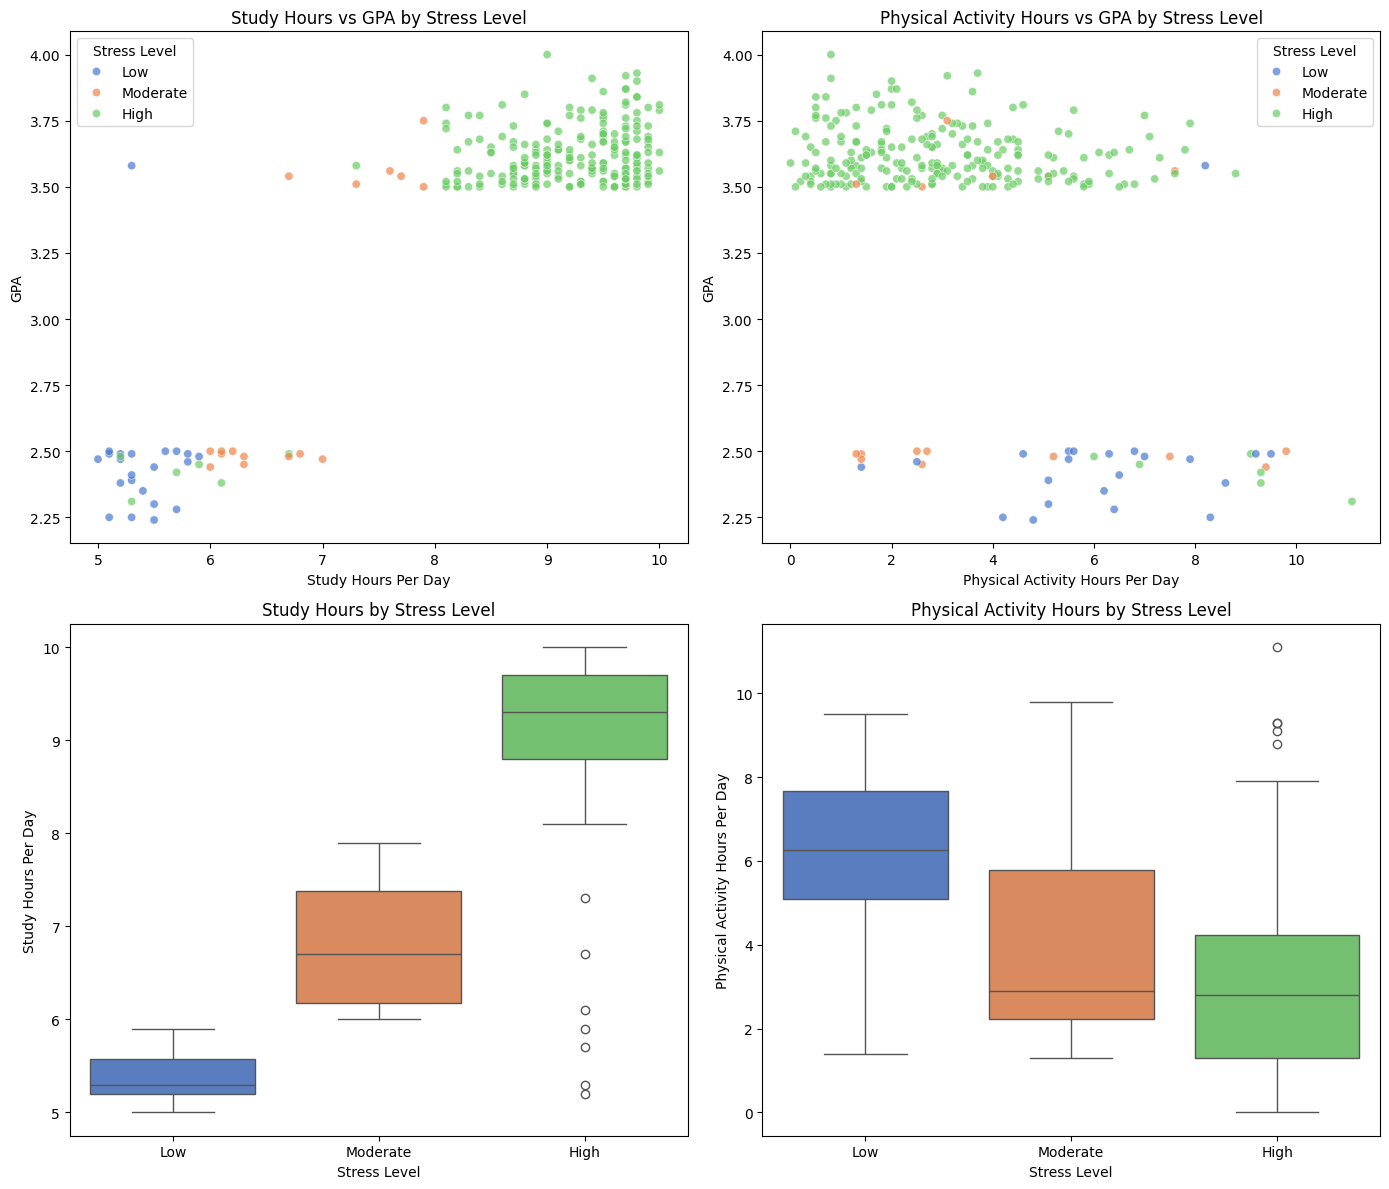

In [19]:
# Combine low and high GPA students for comparison
low_high_gpa_comparison = pd.concat([low_gpa_students, high_gpa_students])

# Create scatter plots to compare study hours and physical activity hours with stress level and GPA
plt.figure(figsize=(14, 12))

# Study Hours vs GPA
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='Study_Hours_Per_Day', 
    y='GPA', 
    hue='Stress_Level', 
    data=low_high_gpa_comparison, 
    palette='muted', 
    alpha=0.7
)
plt.title('Study Hours vs GPA by Stress Level')
plt.xlabel('Study Hours Per Day')
plt.ylabel('GPA')
plt.legend(title='Stress Level')

# Physical Activity Hours vs GPA
plt.subplot(2, 2, 2)
sns.scatterplot(
    x='Physical_Activity_Hours_Per_Day', 
    y='GPA', 
    hue='Stress_Level', 
    data=low_high_gpa_comparison, 
    palette='muted', 
    alpha=0.7
)
plt.title('Physical Activity Hours vs GPA by Stress Level')
plt.xlabel('Physical Activity Hours Per Day')
plt.ylabel('GPA')
plt.legend(title='Stress Level')

# Study Hours vs Stress Level
plt.subplot(2, 2, 3)
sns.boxplot(
    x='Stress_Level', 
    y='Study_Hours_Per_Day', 
    data=low_high_gpa_comparison, 
    palette='muted'
)
plt.title('Study Hours by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Study Hours Per Day')

# Physical Activity Hours vs Stress Level
plt.subplot(2, 2, 4)
sns.boxplot(
    x='Stress_Level', 
    y='Physical_Activity_Hours_Per_Day', 
    data=low_high_gpa_comparison, 
    palette='muted'
)
plt.title('Physical Activity Hours by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Physical Activity Hours Per Day')

plt.tight_layout()
plt.show()

Wawasan tentang Stress_Level pada Mahasiswa dengan GPA Rendah dan Tinggi

**Mahasiswa dengan GPA Rendah**

* **Low:** 56.8% termasuk dalam kategori ini, mungkin mencerminkan kurangnya motivasi atau tekanan akademik.

* **Moderate:** 27.0% berada pada tingkat Stress_Level sedang.

* **High:** 16.2% berada pada tingkat Stress_Level tinggi, menunjukkan bahwa stres berlebihan dapat berdampak negatif pada performa akademik.

**Mahasiswa dengan GPA Tinggi**

* **High:** 96.8% berada pada tingkat Stress_Level tinggi, menunjukkan dorongan akademik yang kuat yang berkaitan dengan stres.

* **Moderate:** Hanya 2.7% berada pada tingkat Stress_Level sedang.

* **Low:** Hanya 0.5% berada pada tingkat Stress_Level rendah, mengindikasikan bahwa stres minimal jarang menghasilkan performa akademik terbaik.

**Pengamatan Utama**

* **Stress_Level dan GPA:** Stress_Level tinggi umum ditemukan pada mahasiswa dengan GPA tinggi, sedangkan Stress_Level rendah lebih sering ditemukan pada mahasiswa dengan GPA rendah.

* **Moderate:** Stress_Level sedang tampaknya mendukung performa akademik yang stabil, tetapi relatif jarang pada mahasiswa berprestasi tinggi.

In [20]:
# Identify the maximum and minimum GPA in the dataset
max_gpa = df['GPA'].max()
min_gpa = df['GPA'].min()

# Count the number of students with maximum and minimum GPA
num_students_max_gpa = df[df['GPA'] == max_gpa].shape[0]
num_students_min_gpa = df[df['GPA'] == min_gpa].shape[0]

max_gpa_info = {
    "Max GPA": max_gpa,
    "Number of Students with Max GPA": num_students_max_gpa
}

min_gpa_info = {
    "Min GPA": min_gpa,
    "Number of Students with Min GPA": num_students_min_gpa
}

print("--- GPA Summary Statistics ---\n")
print("Maximum GPA Information:")
for key, value in max_gpa_info.items():
    print(f"- {key}: {value}")

print("\nMinimum GPA Information:")
for key, value in min_gpa_info.items():
    print(f"- {key}: {value}")

--- GPA Summary Statistics ---

Maximum GPA Information:
- Max GPA: 4.0
- Number of Students with Max GPA: 1

Minimum GPA Information:
- Min GPA: 2.24
- Number of Students with Min GPA: 1


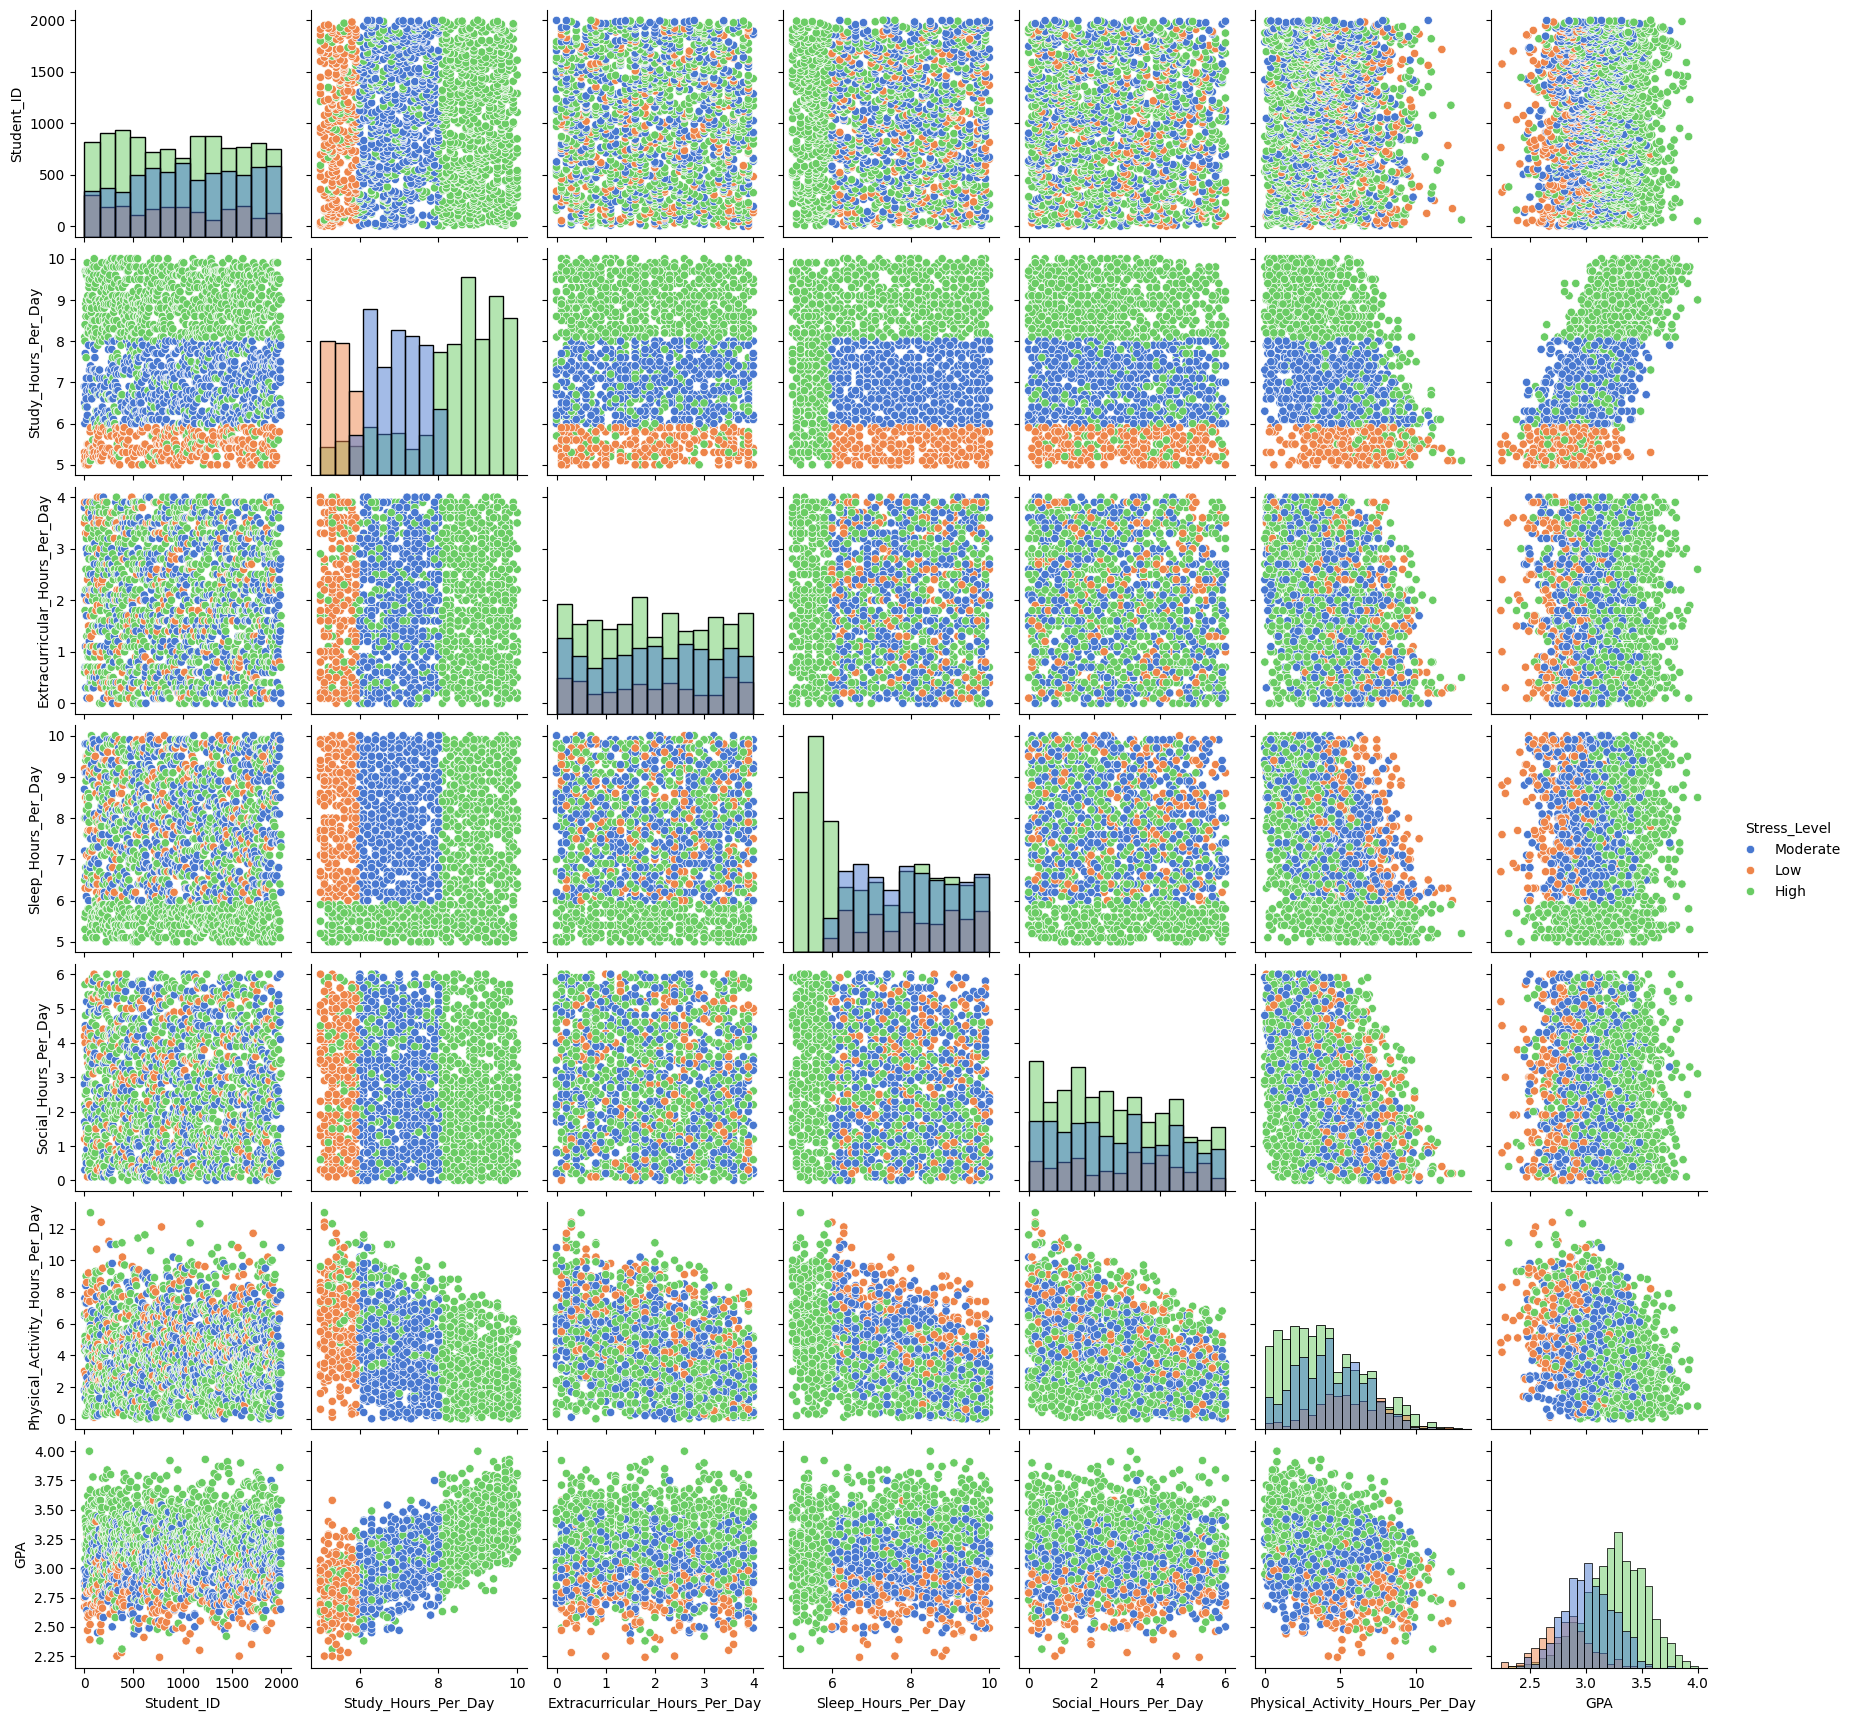

In [21]:
sns.pairplot(df, hue='Stress_Level', diag_kind='hist', palette='muted')

Wawasan dari PairPlot

**Stress_Level = High**

* Study_Hours_Per_Day cenderung lebih tinggi dan berkorelasi dengan GPA yang lebih tinggi.

* Physical_Activity_Hours_Per_Day umumnya lebih rendah pada kelompok ini.

**Stress_Level = Moderate**

* Menunjukkan keseimbangan antara Study_Hours_Per_Day, GPA, dan Physical_Activity_Hours_Per_Day.

* GPA berada pada kisaran sedang dengan distribusi yang relatif stabil.

**Stress_Level = Low**

* Study_Hours_Per_Day lebih rendah dibandingkan kategori lain.

* Physical_Activity_Hours_Per_Day lebih tinggi.

* GPA cenderung lebih rendah secara keseluruhan.

**Pengamatan Utama**

* **High:** Fokus kuat pada Study_Hours_Per_Day meningkatkan GPA, tetapi mengurangi Physical_Activity_Hours_Per_Day.

* **Moderate:** Memberikan keseimbangan antara performa akademik dan aktivitas fisik dengan hasil GPA yang layak.

* **Low:** Prioritas yang lebih besar pada Physical_Activity_Hours_Per_Day dibandingkan Study_Hours_Per_Day berkaitan dengan GPA yang lebih rendah.


# Data Preprocessing

Creating New Features for Deeper Insights

In [22]:
# Creating New Features for Deeper Insights

# Define a function to categorize academic performance based on GPA
def categorize_academic_performance(gpa):
    if gpa >= 3.5:
        return 'Excellent'
    elif 3.0 <= gpa < 3.5:  
        return 'Good'
    elif 2.0 <= gpa < 3.0:  
        return 'Fair'
    else:
        return 'Poor'

# Apply the function to create a new column for academic performance
df['Academic_Performance'] = df['GPA'].apply(categorize_academic_performance)

# Display the counts of each category for verification
academic_performance_counts = df['Academic_Performance'].value_counts()

# Display the results
academic_performance_counts

Academic_Performance
Good         1067
Fair          712
Excellent     221
Name: count, dtype: int64

Kategorisasi Prestasi Akademik

Fitur **Prestasi Akademik** telah dikelompokkan sebagai berikut:

* **Good (3,0 – 3,49):** 1.067 siswa
* **Fair (2,0 – 2,99):** 712 siswa
* **Excellent (3,5 – 4,0):** 221 siswa
* **Poor (< 2,0):** 0 siswa

Distribusi ini menunjukkan bahwa sebagian besar siswa berada dalam rentang GPA **Good** dan **Fair**, dengan sangat sedikit yang mencapai nilai **Excellent** dan tidak ada yang berada dalam kategori **Poor**.

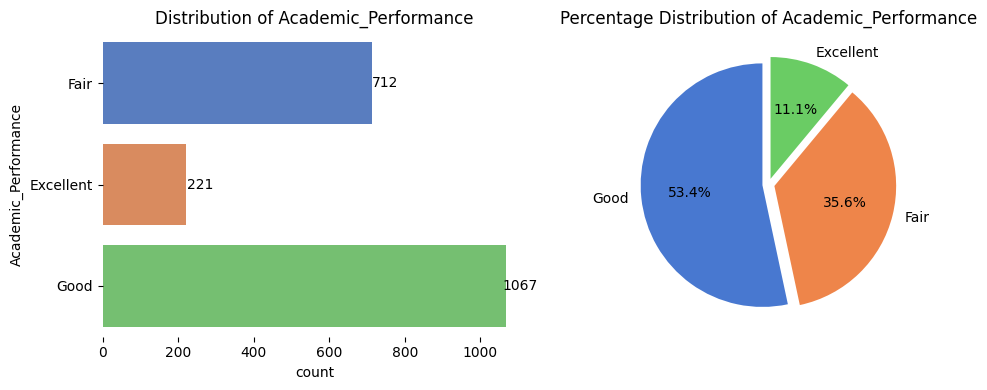

In [23]:
column_name = 'Academic_Performance'
plt.figure(figsize=(10, 4))

# First subplot: Count plot
plt.subplot(1, 2, 1)
sns.countplot(y=column_name, data=df, palette='muted')  
plt.title(f'Distribution of {column_name}')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='center', va='center', xytext=(10, 0), textcoords='offset points')

sns.despine(left=True, bottom=True)

# Second subplot: Pie chart
plt.subplot(1, 2, 2)
df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*df[column_name].nunique())
plt.title(f'Percentage Distribution of {column_name}')
plt.ylabel('')  

plt.tight_layout()
plt.show()

Wawasan dari Distribusi Prestasi Akademik

* **Good (53,4%):** Sebagian besar siswa memiliki GPA antara 3,0 – 3,49, menjadikan kategori ini sebagai kelompok terbesar.  
* **Fair (35,6%):** Sebagian besar siswa berada dalam kisaran GPA 2,0 – 2,99.  
* **Excellent (11,1%):** Hanya sebagian kecil siswa yang mencapai GPA tertinggi, yaitu 3,5 – 4,0.  
* **Poor (0%):** Tidak ada siswa yang memiliki GPA di bawah 2,0.

### Pengamatan Utama

* Mayoritas siswa berada pada tingkat prestasi akademik **Good**, namun belum mencapai kategori **Excellent**.  
* Terdapat potensi untuk mendukung siswa dalam kategori **Good** agar dapat meningkatkan prestasi akademik mereka menuju kategori **Excellent**.


In [24]:
# Encoding Stress_Level and Academic_Performance with explicit ordinal mappings

# Mapping for Stress_Level (ordinal encoding)
mapping_stress = {'Low': 0, 'Moderate': 1, 'High': 2}
df['Stress_Level_Encoded'] = df['Stress_Level'].map(mapping_stress)

# Mapping for Academic_Performance (ordinal encoding)
mapping_performance = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
df['Academic_Performance_Encoded'] = df['Academic_Performance'].map(mapping_performance)

# Display the first few rows of the dataset to verify the new columns
df[['Stress_Level', 'Stress_Level_Encoded', 'Academic_Performance', 'Academic_Performance_Encoded']].head(10)

Stress_Level  Stress_Level_Encoded Academic_Performance  \
0     Moderate                     1                 Fair   
1          Low                     0                 Fair   
2          Low                     0                 Fair   
3     Moderate                     1                 Fair   
4         High                     2            Excellent   
5     Moderate                     1                 Fair   
6         High                     2                 Good   
7         High                     2                 Good   
8          Low                     0                 Fair   
9     Moderate                     1                 Fair   

   Academic_Performance_Encoded  
0                             1  
1                             1  
2                             1  
3                             1  
4                             3  
5                             1  
6                             2  
7                             2  
8                             1  
9                             1

In [25]:
# Drop the original categorical columns
df = df.drop(columns=['Stress_Level', 'Academic_Performance'])

# Verify the updated dataset
df.head()

Student_ID  Study_Hours_Per_Day  Extracurricular_Hours_Per_Day  \
0           1                  6.9                            3.8   
1           2                  5.3                            3.5   
2           3                  5.1                            3.9   
3           4                  6.5                            2.1   
4           5                  8.1                            0.6   

   Sleep_Hours_Per_Day  Social_Hours_Per_Day  Physical_Activity_Hours_Per_Day  \
0                  8.7                   2.8                              1.8   
1                  8.0                   4.2                              3.0   
2                  9.2                   1.2                              4.6   
3                  7.2                   1.7                              6.5   
4                  6.5                   2.2                              6.6   

    GPA  Stress_Level_Encoded  Academic_Performance_Encoded  
0  2.99                     1                             1  
1  2.75                     0                             1  
2  2.67                     0                             1  
3  2.88                     1                             1  
4  3.51                     2                             3

In [26]:
# Creating a table for correlation of the target variable 'Stress_Level_Encoded' with other features
target_variable = 'Stress_Level_Encoded'
target_correlation_table = df.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)

# Displaying the table
target_correlation_table

Stress_Level_Encoded
Stress_Level_Encoded                         1.000000
Study_Hours_Per_Day                          0.738843
GPA                                          0.550395
Academic_Performance_Encoded                 0.504442
Student_ID                                   0.003306
Extracurricular_Hours_Per_Day               -0.006099
Social_Hours_Per_Day                        -0.054702
Physical_Activity_Hours_Per_Day             -0.205207
Sleep_Hours_Per_Day                         -0.298917

Wawasan dari Tabel Korelasi (Target: Encoded_Stress_Level)

**Korelasi Positif**

* **Study_Hours_Per_Day (0.7388):** Korelasi positif terkuat; siswa dengan tingkat stres lebih tinggi cenderung belajar lebih lama.

* **GPA (0.5504):** Korelasi positif sedang; tingkat stres yang lebih tinggi berkaitan dengan performa akademik yang lebih baik.

* **Encoded_Academic_Performance (0.5044):** Siswa dengan tingkat stres lebih tinggi sering berada pada kategori prestasi akademik yang lebih tinggi (**Good**, **Excellent**).

**Korelasi Positif Lemah**

* **Student_ID (0.0033):** Korelasi dapat diabaikan dan tidak memiliki makna analitis karena hanya sebagai identifier.

**Korelasi Negatif**

* **Sleep_Hours_Per_Day (-0.2989):** Korelasi negatif sedang; peningkatan tingkat stres cenderung mengurangi durasi tidur.

* **Physical_Activity_Hours_Per_Day (-0.2052):** Siswa dengan stres lebih tinggi umumnya memiliki waktu aktivitas fisik yang lebih rendah.

* **Social_Hours_Per_Day (-0.0547):** Korelasi negatif lemah; siswa dengan stres tinggi sedikit kurang bersosialisasi.

* **Extracurricular_Hours_Per_Day (-0.0061):** Korelasi negatif sangat lemah; aktivitas ekstrakurikuler memiliki pengaruh minimal terhadap tingkat stres.


In [27]:
# Define the features (X) and the target variable (y)
X = df.drop(columns=['Student_ID', 'Stress_Level_Encoded'])  
y = df['Stress_Level_Encoded']  

# Display shapes to confirm the split
print("X Shape:", X.shape)
print("\ny Shape:", y.shape)

X Shape: (2000, 7)

y Shape: (2000,)


In [28]:
# # Outlier detection using Isolation Forest
# iso_forest = IsolationForest(contamination=0.01, random_state=42)
# outlier_predictions = iso_forest.fit_predict(X)

# # Identify outliers: Isolation Forest marks outliers as -1
# outlier_indices = X.index[outlier_predictions == -1]

# # Print the number of outliers detected
# print(f"Number of detected outliers: {len(outlier_indices)}")

In [29]:
# # Remove outliers
# X_filtered = X.drop(outlier_indices, axis=0).reset_index(drop=True)
# y_filtered = y.drop(outlier_indices, axis=0).reset_index(drop=True)

# print(f"New shape of X after removing outliers: {X_filtered.shape}")
# print(f"New shape of y after removing outliers: {y_filtered.shape}")

In [30]:
# Save the preprocessed dataset (no row removal)
# preprocessed_df = df.drop(index=outlier_indices).reset_index(drop=True)
preprocessed_df = df.reset_index(drop=True)

preprocessed_dir = Path('../datasets/preprocessed')
preprocessed_dir.mkdir(parents=True, exist_ok=True)
preprocessed_path = preprocessed_dir / 'student_lifestyle_dataset_preprocessed.csv'
preprocessed_df.to_csv(preprocessed_path, index=False)

print(f"Preprocessed dataset saved to {preprocessed_path.resolve()}")

Preprocessed dataset saved to D:\projects\Nostressia\Nostressia-ML\Current-Stress\datasets\preprocessed\student_lifestyle_dataset_preprocessed.csv


In [31]:
# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # menjaga proporsi kelas stres
)

# Display the shapes of the splits for verification
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (1600, 7)
X_test Shape: (400, 7)
y_train Shape: (1600,)
y_test Shape: (400,)


In [32]:
iso = IsolationForest(contamination=0.01, random_state=42)

# Fit hanya di data train
train_pred = iso.fit_predict(X_train)
test_pred  = iso.predict(X_test)

train_pred[:10]

n_outlier_train = np.sum(train_pred == -1)
n_outlier_test  = np.sum(test_pred == -1)

print("Outlier train:", n_outlier_train)
print("Outlier test :", n_outlier_test)


Outlier train: 16
Outlier test : 2


In [33]:
# # Apply RobustScaler
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Scaling akan dilakukan di dalam Pipeline, jadi tidak perlu scaling manual di sini.

# Model Training and Evaluation

In [34]:
# Initialize models
models = {
    # Scaling sensitive LR → wrap pipeline to be fair
    "Logistic Regression (Scaled)": Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("lr", LogisticRegression(random_state=42, max_iter=1000))
    ]),

    # Tree-based safe without scaling
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

print("Models initialized:", list(models.keys()))


Models initialized: ['Logistic Regression (Scaled)', 'Decision Tree', 'Random Forest']


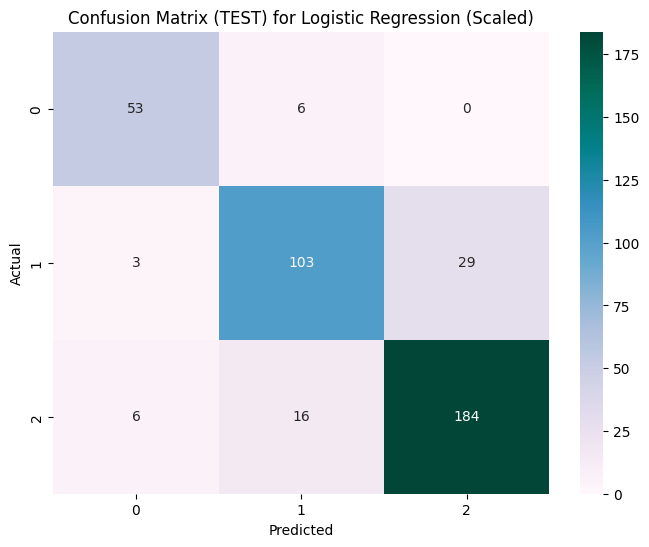


Classification Report (TEST) for Logistic Regression (Scaled):

              precision    recall  f1-score   support

           0       0.85      0.90      0.88        59
           1       0.82      0.76      0.79       135
           2       0.86      0.89      0.88       206

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



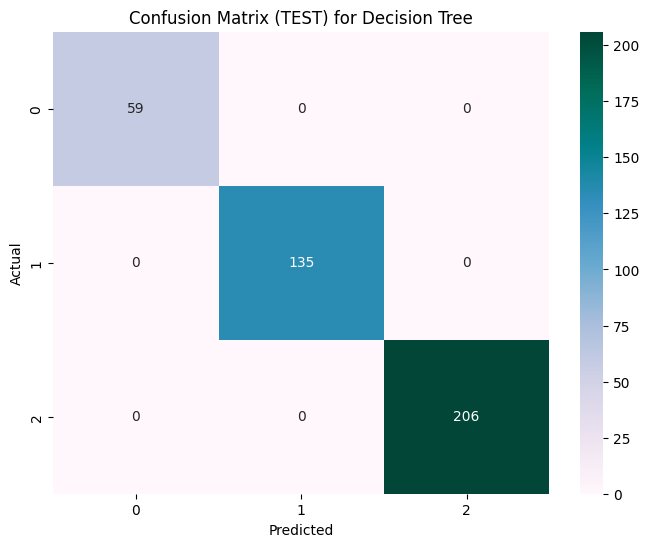


Classification Report (TEST) for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       206

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



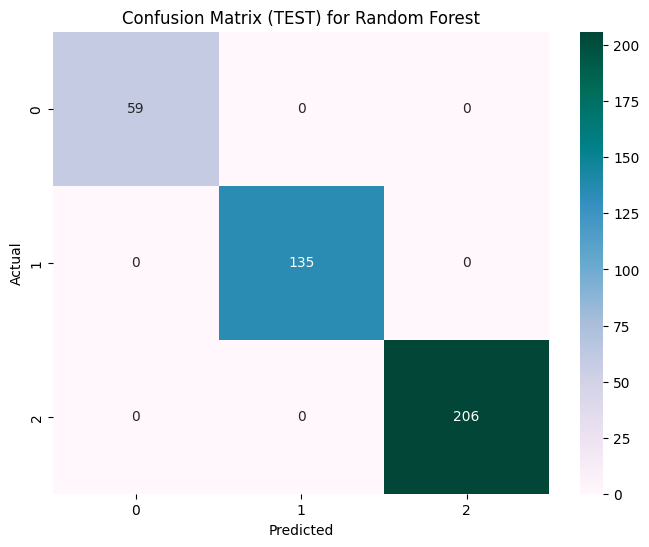


Classification Report (TEST) for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       206

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Model Evaluation Summary (TEST):



Accuracy       AUC
Logistic Regression (Scaled)      0.85  0.956766
Decision Tree                     1.00  1.000000
Random Forest                     1.00  1.000000

In [35]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)

        # Calculate metrics on the TEST data (lebih valid)
        accuracy = accuracy_score(y_test, preds)
        auc = (
            roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")
            if hasattr(model, 'predict_proba') else 'N/A'
        )

        results[name] = {
            'Accuracy': accuracy,
            'AUC': auc
        }

        # Confusion matrix for TEST data
        conf_matrix = confusion_matrix(y_test, preds)
        plt.figure(figsize=(8, 6))
        classes = np.unique(y_test)
        sns.heatmap(
            conf_matrix, annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=classes, yticklabels=classes
        )
        plt.title(f'Confusion Matrix (TEST) for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Classification report for TEST data
        print(f"\nClassification Report (TEST) for {name}:\n")
        print(classification_report(y_test, preds))

    results_df = pd.DataFrame(results).T

    print("\nModel Evaluation Summary (TEST):\n")
    return results_df

evaluation_summary = train_and_evaluate_models(models, X_train, y_train, X_test, y_test)
evaluation_summary


Pengamatan Kinerja Model

**Logistic Regression**

* Accuracy: 83%, AUC: 0.95  
* Berkinerja baik dan sangat mudah diinterpretasikan.  
* Kinerja sedikit lebih rendah dibandingkan model berbasis pohon karena mengasumsikan hubungan linier antar fitur.

**Decision Tree**

* Accuracy: 100%, AUC: 100%  
* Sangat sesuai dengan data pelatihan, namun berisiko mengalami overfitting dan memiliki kemampuan generalisasi yang rendah.

**Random Forest**

* Accuracy: 100%, AUC: 100%  
* Menawarkan generalisasi yang lebih baik dibandingkan Decision Tree tunggal melalui pendekatan ensemble, sambil mempertahankan performa pelatihan yang sangat tinggi.


In [36]:
base_models = [
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
]

meta_model = RandomForestClassifier(random_state=42, n_jobs=-1)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

pipeline_model = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('model', stacking_model)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline_model,
    X_train, y_train,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

pipeline_model.fit(X_train, y_train)
test_accuracy = pipeline_model.score(X_test, y_test)

print("CV scores:", cv_scores)
print("Mean CV:", cv_scores.mean())
print("Test accuracy:", test_accuracy)

CV scores: [1. 1. 1. 1. 1.]
Mean CV: 1.0
Test accuracy: 1.0


Pengamatan Model Stacking

* Model stacking mencapai **akurasi sempurna** baik pada proses validasi silang maupun pada data pengujian.

* Hal ini menunjukkan bahwa pendekatan ensemble mampu mengombinasikan keunggulan model dasar **Logistic Regression**, **Random Forest**, dan **Decision Tree**, dengan dukungan meta-model (**Random Forest**) untuk menghasilkan kinerja prediksi yang optimal dan stabil.

Key Factors Driving Stress Predictions

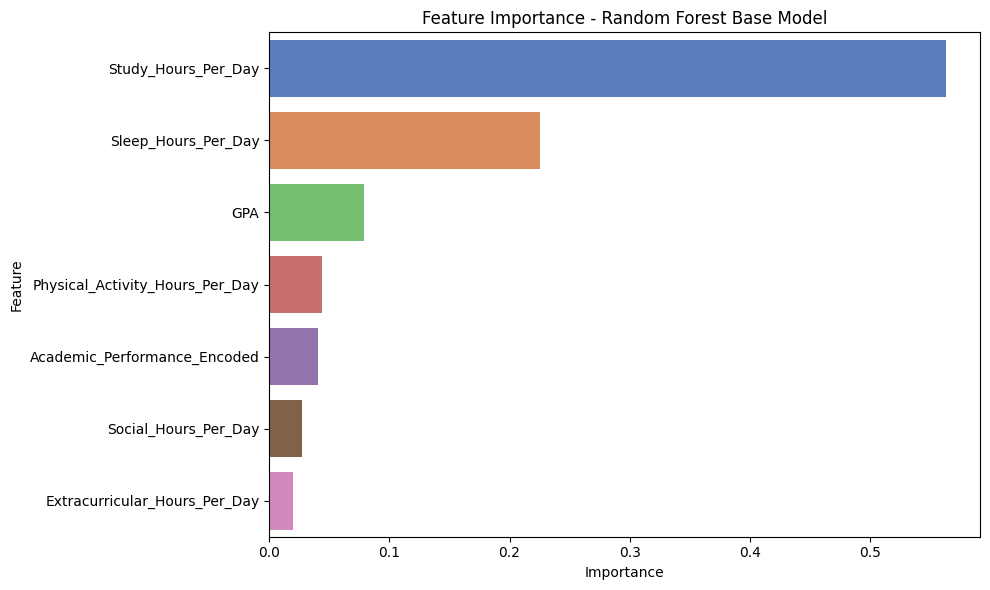

In [37]:
# Use the feature names from the original DataFrame
feature_names = X.columns  # Retrieve feature names from the original DataFrame

# Extract feature importance from the Random Forest base model
stacking_fitted = pipeline_model.named_steps['model']
rf_base_model = stacking_fitted.named_estimators_['rf']  # Access Random Forest base model
rf_feature_importances = rf_base_model.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='muted')
plt.title('Feature Importance - Random Forest Base Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Wawasan Pentingnya Fitur

**Fitur Utama yang Diidentifikasi oleh Model Random Forest:**

* **Study_Hours_Per_Day:**

  * Fitur paling berpengaruh untuk memprediksi stres.

  * Lebih banyak jam belajar sangat terkait dengan tingkat stres yang lebih tinggi.

* **Sleep_Hours_Per_Day:**

  * Fitur terpenting kedua.

  * Kurang tidur dikaitkan dengan peningkatan stres.

* **GPA:**

  * Prestasi akademik memengaruhi pola stres, kemungkinan karena tekanan akademik.

* **Physical_Activity_Hours_Per_Day:**

  * Cukup penting.

  * Lebih banyak aktivitas fisik dikaitkan dengan tingkat stres yang lebih rendah.

* **Academic_Performance_Encoded:**

  * Berkontribusi pada prediksi stres, meskipun kurang dari GPA.

* **Extracurricular_Hours_Per_Day:**

  * Fitur yang paling tidak penting.

  * Bersosialisasi dan keterlibatan ekstrakurikuler memiliki dampak langsung minimal terhadap stres.

**Pengamatan Utama:**

* **Manajemen Waktu:** Menyeimbangkan belajar dan tidur sangat penting untuk mengurangi stres.

* **Kesehatan & Gaya Hidup:** Aktivitas fisik cukup membantu mengelola stres.

* **Tekanan Akademik:** GPA tinggi dan tuntutan akademik berkontribusi pada stres, menunjukkan pentingnya dukungan akademik.

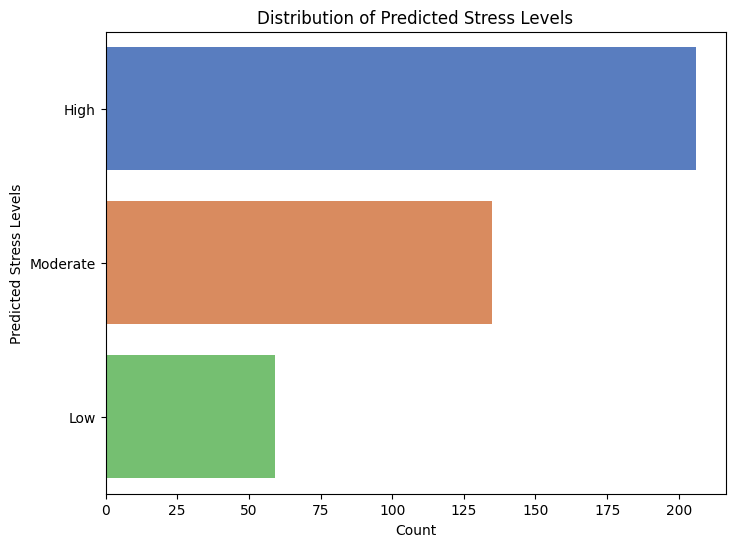

In [38]:
# Generate predictions on the test set using the PIPELINE (includes scaling)
y_pred = pipeline_model.predict(X_test)

# Map the encoded predictions back to the original stress level categories
mapping_stress_reverse = {0: 'Low', 1: 'Moderate', 2: 'High'}
y_pred_mapped = pd.Series(y_pred).map(mapping_stress_reverse)

# Plot the distribution of predicted stress levels
plt.figure(figsize=(8, 6))
sns.countplot(y=y_pred_mapped, palette='muted')
plt.title('Distribution of Predicted Stress Levels')
plt.xlabel('Count')
plt.ylabel('Predicted Stress Levels')
plt.show()


Wawasan Distribusi Stress_Level

* **High:**

  * Sebagian besar siswa diprediksi berada pada Stress_Level **High**.  
  * Menunjukkan tekanan akademik dan faktor gaya hidup yang signifikan memengaruhi mayoritas siswa.

* **Moderate:**

  * Sebagian besar siswa berada pada Stress_Level **Moderate**.  
  * Mencerminkan gaya hidup yang relatif seimbang, di mana stres tetap ada namun masih dapat dikelola.

* **Low:**

  * Hanya sebagian kecil siswa berada pada Stress_Level **Low**.  
  * Menunjukkan bahwa mempertahankan rutinitas dengan stres rendah relatif jarang, kemungkinan akibat tingginya tuntutan akademik.


In [39]:
# Save the trained pipeline model and feature names
model_artifacts = {
    'pipeline': pipeline_model,
    'feature_names': list(feature_names)
}

models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / 'current_stress_pipeline.joblib'
joblib.dump(model_artifacts, model_path)

print(f"Model artifacts saved to {model_path.resolve()}")


Model artifacts saved to D:\projects\Nostressia\Nostressia-ML\Current-Stress\models\current_stress_pipeline.joblib


# Try Model

Bagian ini digunakan untuk mencoba artifact model yang sudah tersimpan tanpa menjalankan ulang proses training.  
Output berisi prediksi `Stress_Level` beserta probabilitas (jika tersedia).


In [40]:
# TRY MODEL (INDEPENDENT)
import numpy as np
import pandas as pd
from pathlib import Path
import joblib

# Artifact path
ARTIFACT_CANDIDATES = [
    Path("../models/current_stress_pipeline.joblib"),
]
ARTIFACT_PATH = next((p for p in ARTIFACT_CANDIDATES if p.exists()), None)
if ARTIFACT_PATH is None:
    raise FileNotFoundError("Model artifact not found. Expected: ../models/current_stress_pipeline.joblib")

artifact = joblib.load(ARTIFACT_PATH)
pipeline = artifact.get("pipeline", None)
feature_names = artifact.get("feature_names", None)

if pipeline is None or feature_names is None:
    raise ValueError("Invalid artifact format. Keys required: 'pipeline' and 'feature_names'.")

feature_names = list(feature_names)

# Dataset path (prefer preprocessed)
DATA_CANDIDATES = [
    Path("../datasets/preprocessed/student_lifestyle_dataset_preprocessed.csv"),
    Path("../datasets/raw/student_lifestyle_dataset.csv"),
]
DATA_PATH = next((p for p in DATA_CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Dataset not found. Expected one of: "
        "../datasets/preprocessed/student_lifestyle_dataset_preprocessed.csv or "
        "../datasets/raw/student_lifestyle_dataset.csv"
    )

df = pd.read_csv(DATA_PATH)

# If raw dataset is used, apply the minimum preprocessing expected by training
# (create Academic_Performance, encode targets, and drop original categorical columns)
if "Stress_Level_Encoded" not in df.columns and "Stress_Level" in df.columns:
    # Academic_Performance creation (based on GPA)
    if "Academic_Performance" not in df.columns:
        if "GPA" not in df.columns:
            raise KeyError("Raw dataset requires 'GPA' column to create 'Academic_Performance'.")
        def categorize_academic_performance(gpa):
            if gpa >= 3.5:
                return "Excellent"
            if 3.0 <= gpa < 3.5:
                return "Good"
            if 2.0 <= gpa < 3.0:
                return "Fair"
            return "Poor"
        df["Academic_Performance"] = df["GPA"].apply(categorize_academic_performance)

    # Ordinal encodings (must match training)
    mapping_stress = {"Low": 0, "Moderate": 1, "High": 2}
    mapping_performance = {"Poor": 0, "Fair": 1, "Good": 2, "Excellent": 3}

    if df["Stress_Level"].isna().any():
        raise ValueError("Raw dataset contains missing values in 'Stress_Level'.")
    df["Stress_Level_Encoded"] = df["Stress_Level"].map(mapping_stress)
    df["Academic_Performance_Encoded"] = df["Academic_Performance"].map(mapping_performance)

    if df["Stress_Level_Encoded"].isna().any():
        raise ValueError("Unexpected categories in 'Stress_Level'. Expected: Low, Moderate, High.")
    if df["Academic_Performance_Encoded"].isna().any():
        raise ValueError("Unexpected categories in 'Academic_Performance'. Expected: Poor, Fair, Good, Excellent.")

    # Drop original categorical columns used to create encodings
    drop_cols = [c for c in ["Stress_Level", "Academic_Performance"] if c in df.columns]
    if len(drop_cols) > 0:
        df = df.drop(columns=drop_cols)

# Build X for inference using artifact feature_names
missing = [c for c in feature_names if c not in df.columns]
if len(missing) > 0:
    raise KeyError(f"Dataset is missing required feature columns: {missing}")

X_try = df[feature_names].copy()

# Run inference on a small sample
SAMPLE_N = 10
X_sample = X_try.head(SAMPLE_N)

pred = pipeline.predict(X_sample)

# Probability handling (if available)
proba = None
if hasattr(pipeline, "predict_proba"):
    try:
        proba = pipeline.predict_proba(X_sample)
    except Exception:
        proba = None

label_map = {0: "Low", 1: "Moderate", 2: "High"}
pred_label = [label_map.get(int(v), str(v)) for v in pred]

out = pd.DataFrame({"pred_encoded": pred.astype(int), "pred_label": pred_label})

if proba is not None and isinstance(proba, np.ndarray) and proba.ndim == 2:
    # columns assume order [0,1,2]
    for k in range(proba.shape[1]):
        out[f"proba_{k}"] = proba[:, k]

print("ARTIFACT_PATH:", str(ARTIFACT_PATH))
print("DATA_PATH    :", str(DATA_PATH))
print("FEATURES_CNT :", len(feature_names))
display(out)

# Optional: prediction distribution on sample
dist = out["pred_label"].value_counts().to_dict()
print("PRED_DIST_SAMPLE:", dist)


ARTIFACT_PATH: ..\models\current_stress_pipeline.joblib
DATA_PATH    : ..\datasets\preprocessed\student_lifestyle_dataset_preprocessed.csv
FEATURES_CNT : 7


pred_encoded pred_label  proba_0  proba_1  proba_2
0             1   Moderate      0.0      1.0      0.0
1             0        Low      1.0      0.0      0.0
2             0        Low      1.0      0.0      0.0
3             1   Moderate      0.0      1.0      0.0
4             2       High      0.0      0.0      1.0
5             1   Moderate      0.0      1.0      0.0
6             2       High      0.0      0.0      1.0
7             2       High      0.0      0.0      1.0
8             0        Low      1.0      0.0      0.0
9             1   Moderate      0.0      1.0      0.0

PRED_DIST_SAMPLE: {'Moderate': 4, 'Low': 3, 'High': 3}
